## **ECM2423 Coursework: Maze solver**

### Prerequisites + Instructions:
Matplotlib, and numpy which comes with it, are needed in order to display the solutions and the analysis plots.  
- Run **`pip install -r requirements.txt`** to install them.


For each algorithm running on a given maze, you can:
- Get the solution using <algo_name>.solution
- Output a solution image <algo_name>.maze_img()
- Output the stats as a string using <algo_name>.stats()
- Write out the solution to a .png and .txt file using <algo_name>.export_solution()

In order to declutter the notebook + improve runtime, I've saved all of the solved maze images into the `solution-images` folder, and all of the solution paths to `solution-paths` folder, using the export_solution() function.

In the notebook, each algorithm will display its stats, but only DFS on Easy will output the solution and maze_img() (as an example of how it can be done).

The analysis class:
- Takes a list of algorithms acting on a given maze, it displays horizontal bar charts to compare stats.
- Can be used to display stats of a single algorithm.

Please ensure all cells are ran sequentially to make sure everything is initialised correctly.


### Utility Code Blocks:

In [27]:
"""Imports"""
import time
import matplotlib.pyplot as plt
import numpy as np
import heapq
import os


In [28]:
"""Maze Class"""
class Maze:
    def __init__(self, filename):
        self.name = filename[11:-4]
        self.grid = []
        self.adjacency_list = {}        
        self.startnode = ()
        self.goalnode = ()

        # Read maze to grid

        with open(filename, 'r') as f:
            for line in f:
                if line != "\n":
                    line = line.replace(" ", "")
                    self.grid.append([c for c in line.strip()])

        # Get the start node (top row, first occurence of "-")
        self.startnode = (0, self.grid[0].index("-"))
        # Get the goal node (bottom row, first occurence of "-")
        maze_height = len(self.grid)
        self.goalnode = (maze_height-1, self.grid[maze_height-1].index("-"))
        self.__generate_adjacency_matrix__()

    def __generate_adjacency_matrix__(self):
        nodes = []
        height = len(self.grid)
        width = len(self.grid[0])

        # Create a list of nodes and a list of neighbours for each node (shared index)
        for i in range(height):
            for j in range(width):
                if self.grid[i][j] == "-":
                    nodes.append((i, j))
                    tmp_adj_list_for_node = []
                    # Collect node's neighbours
                    if (i-1 >= 0) and (self.grid[i-1][j] == "-"):  # down
                        tmp_adj_list_for_node.append(((i-1, j)))  

                    if (j-1 >= 0) and (self.grid[i][j-1] == "-"): # right
                        tmp_adj_list_for_node.append(((i, j-1)))

                    if (j+1 < width) and (self.grid[i][j+1] == "-"): # left
                        tmp_adj_list_for_node.append(((i, j+1)))

                    if (i+1 < height) and (self.grid[i+1][j] == "-"): # up
                        tmp_adj_list_for_node.append(((i+1, j)))
             


                                            
                    # Add node and its connections to adjacency matrix
                    self.adjacency_list[(i, j)] = tmp_adj_list_for_node
        
    def print_adj_matrix(self):
        for ele in self.adjacency_list:
            print(ele, (self.adjacency_list[ele]))
    
    # Admissible heuristic function
    def euclidean_distance(self, node):
        (y, x) = node
        (goal_y, goal_x) = self.goalnode
        return ((y - goal_y)**2 + (x - goal_x)**2)**0.5

    def manhattan_distance(self, node):
        (y, x) = node
        (goal_y, goal_x) = self.goalnode
        return abs(y - goal_y) + abs(x - goal_x)
    
    def __str__(self):
        return ("\n".join([" ".join(row) for row in self.grid]) )


In [29]:
"""Algorithm Superclass"""


class Algorithm:
    def __init__(self, filename):
        self.name = ""

        self.maze = Maze(filename)
        # Time taken for the algorithm to find a solution
        self.time_taken = 0
        # List of coordinates of nodes on solution path: [(y1, x1), (y2, x2), ...]
        self.solution = []

        # Set of coordinates of visited nodes:  ((y1, x1), (y2, x2), ...)
        self.visited = set()

        # Dictionary of each nodes parent using coordinates as keys: {(y1, x1): (y2, x2), ...}
        # To be generated by the algorithm
        self.parent = {}

    # Display the maze utility function
    def maze_img(self, show_solution=True, show_visited=True, save=False):
        output = self.maze.grid.copy()
        if show_visited:
            for visted_node in self.visited:
                output[visted_node[0]][visted_node[1]] = "."
        if show_solution:
            for solution_node in self.solution:
                output[solution_node[0]][solution_node[1]] = "x"
                
        # Map the characters to colors
        colours = {'#': 0.0, '-': 1.0, 'x': 0.5, '.': 0.2}
        maze_img = np.array([[colours[elem] for elem in row] for row in output])

        # Create a new matplotlib figure and plot the maze colors
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(maze_img)

        # Remove the axes and show the plot
        ax.axis('off')
        if not save:
            plt.show()
        else:
            dir_path = "solution-images/" + self.name
            if not os.path.exists(dir_path):
                os.makedirs( dir_path)
            plt.savefig("solution-images/" + self.name + "/" + self.name + "_" + self.maze.name + ".png")

    def export_solution(self):
        self.maze_img(save=True)

        dir_path = "solution-paths/" + self.name

        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

        file = open("solution-paths/" + self.name + "/" + self.name + "_" + self.maze.name + ".txt", "w")
        file.write(str(self.solution))
        file.close()

    def stats(self):
        print("MAZE: " + self.maze.name)
        print("TIME TAKEN TO FIND SOLUTION: " + str(self.time_taken) + " seconds")
        print("NUMBER OF NODES VISITED: " + str(len(self.visited)))
        print("NUMBER OF STEPS IN SOLUTION: " + str(len(self.solution)))
        print("\n")

In [30]:
"""Analysis Class for comparison of algorithms"""
class Analysis:
    def __init__(self, algorithms):
        # Take in a list of algorithms
        self.algorithms = algorithms
        self.labels = []
        # Create labels for the bar charts
        for algorithm in algorithms:
            self.labels.append(algorithm.name + "\n on \n" + algorithm.maze.name)

    # Compare the number of nodes visited by each algorithm
    def __compare_nodes(self, ax):
        ax.set_title("Nodes Visited", fontsize=18)
        ax.set_xlabel("Number of Nodes Visited")
        for i, algorithm in enumerate(self.algorithms):
            bar = ax.barh(i, len(algorithm.visited))
            ax.bar_label(bar, padding=3, fmt = "%g nodes")
            
        ax.set_yticks(range(len(self.algorithms)))
        ax.set_yticklabels(self.labels)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

    # Compare the time taken by each algorithm
    def __compare_time_taken(self, ax):
        ax.set_title("Time Taken", fontsize=18)
        ax.set_xlabel("Time Taken (seconds)")
        for i, algorithm in enumerate(self.algorithms):
            bar = ax.barh(i, algorithm.time_taken)
            ax.bar_label(bar, padding=3, fmt = "%.8f seconds")

        ax.set_yticks(range(len(self.algorithms)))
        ax.set_yticklabels(self.labels)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

    # Compare the length of the solution path by each algorithm
    def __compare_solution_length(self, ax):
        ax.set_title("Solution Length", fontsize=18)
        ax.set_xlabel("Solution Length")
        for i, algorithm in enumerate(self.algorithms):
            bar = ax.barh(i, len(algorithm.solution))
            ax.bar_label(bar, padding=3, fmt = "%g steps")
        ax.set_yticks(range(len(self.algorithms)))
        ax.set_yticklabels(self.labels)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        
    # Display all of the stats in one graph
    def compare_stats(self, fig_size=(20, 5)):
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=fig_size)
        fig.suptitle("Algorithm Stats", fontsize=20)
        self.__compare_nodes(axs[0])
        self.__compare_time_taken(axs[1])
        self.__compare_solution_length(axs[2])
        plt.tight_layout()
        plt.show()


### **Question 1.1: How to frame the maze solver as a search problem.**
- Represent the maze as a graph.
    - Each node in the graph represents a problem-situation (state), a particular position on the maze that can be explored. There are many ways of choosing what we consider to be a node - such as only considering maze-paths where a decision must be made. For simplicity's sake we will represent each maze-path as a node.
    - Arcs are 'actions' - possible moves from one state to another. The arc's cost (or weight) would be the number of steps required to get from the current node to that node. In the case where each maze-path is considered a node, each arc can be considered to have a cost of 1 (alternatively, the whole graph can be treated as a uniform graph where path length = number of path nodes).
- Define a starting node and a goal node.
- Apply a search algorithm (such as DFS, BFS, Greedy Search) to find the goal node from the start node.
- The path cost will be the number of steps needed to reach the goal node from the start node according to that algorithm.

A Problem in statespace search = (State space, start, goal condition)

### **Question 1.2: Solving the maze using depth-first search.**

#### **1.2.1 The depth-first algorithm:**

The core idea is to explore as deep as possible before backtracking. 

**Steps are as follows:**

1. Initialise a stack with the start node.
2. While the stack is not empty:
    1. Pop a node from the stack, call it the current node
    2. If the current node hasn't been visited:
        1. Mark the current node as visited
        2. If the current node is the goal node:
            - Construct the solution path using the parents of each node and stop searching.
        3. Add each unvisited neighbour to the stack


In [31]:
"""1.2 DFS Algorithm Implementation (as a class)"""
class DFS(Algorithm):
    def __init__(self, filename):
        super().__init__(filename)

        self.name = "DFS"
        print("ALGORITHM: " + self.name)
        start_time = time.time()

        source = self.maze.startnode
        goal = self.maze.goalnode
        graph = self.maze.adjacency_list

        parent = self.parent

        # Create a stack for DFS (LIFO)
        stack = [source]

        # Add source node to parent dictionary
        parent[source] = None
        
        # Traverse the graph using DFS
        while stack:
            # Pop the next node from the stack (LIFO)
            current = stack.pop()
            if current not in self.visited:
            # Add current node to the visited set
                self.visited.add(current)
                # If the current node is the goal, reconstruct and set the solution path
                if current == goal:
                    path = [current]
                    while path[-1] != source:
                        path.append(parent[path[-1]])
                    path.reverse()
                    self.solution = path
                    self.steps = len(path)
                    self.time_taken = time.time() - start_time
                    return
                # Add the neighbours of the current node to the stack (provided they havent been visited)
                for neighbour in graph[current]:
                    if neighbour not in self.visited:
                        parent[neighbour] = current
                        stack.append(neighbour)

        return

ALGORITHM: DFS
MAZE: Easy
TIME TAKEN TO FIND SOLUTION: 0.0 seconds
NUMBER OF NODES VISITED: 46
NUMBER OF STEPS IN SOLUTION: 27


SOLUTION PATH: [(0, 1), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 5), (3, 5), (4, 5), (5, 5), (5, 6), (5, 7), (5, 8), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (6, 16), (6, 17), (7, 17), (8, 17), (8, 18), (9, 18)]


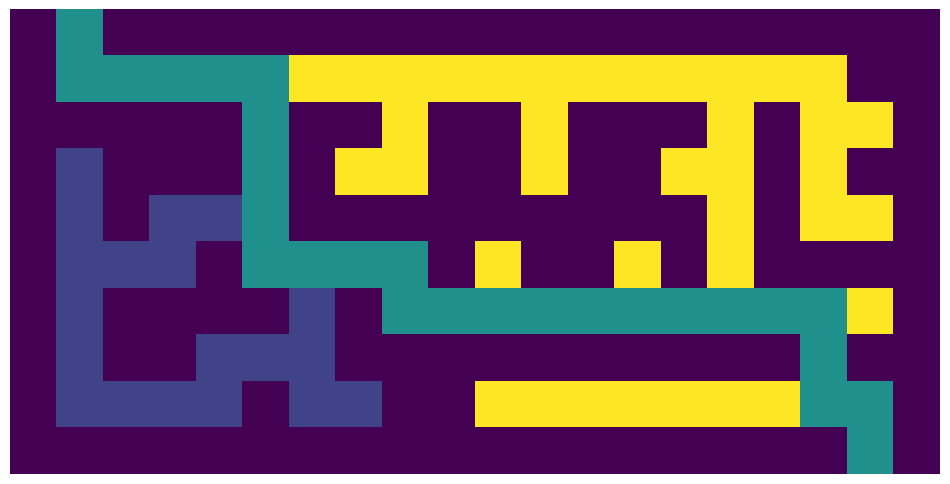

ALGORITHM: DFS
MAZE: Medium
TIME TAKEN TO FIND SOLUTION: 0.006382465362548828 seconds
NUMBER OF NODES VISITED: 2494
NUMBER OF STEPS IN SOLUTION: 339


ALGORITHM: DFS
MAZE: Large
TIME TAKEN TO FIND SOLUTION: 0.013151407241821289 seconds
NUMBER OF NODES VISITED: 10309
NUMBER OF STEPS IN SOLUTION: 1092


ALGORITHM: DFS
MAZE: VLarge
TIME TAKEN TO FIND SOLUTION: 0.2876453399658203 seconds
NUMBER OF NODES VISITED: 113323
NUMBER OF STEPS IN SOLUTION: 3737




In [32]:
"""1.2 Running DFS on the 4 mazes"""

dfs_easy = DFS("mazes/maze-Easy.txt")
dfs_easy.stats()
print("SOLUTION PATH: " + str(dfs_easy.solution))  # You can print the nodes in solution path in solution path, if need be
dfs_easy.maze_img(show_solution=True,show_visited=True) # I prefer the images though, although computationally expensive

dfs_medium = DFS("mazes/maze-Medium.txt")
dfs_medium.stats()
# dfs_medium.maze_img()


dfs_large = DFS("mazes/maze-Large.txt")
dfs_large.stats()
# dfs_large.maze_img()

dfs_vlarge = DFS("mazes/maze-VLarge.txt")
dfs_vlarge.stats()
# dfs_vlarge.maze_img()

### **1.3 Alternative algorithm: A-Star Search**

#### **1.3.1 A-Star Search:**

The core idea is to evaluate nodes by the cost it takes to get to them and the estimated remaining cheapest cost to the goal node using a hueristic. 

Evalutation function **f(n) = g(n) + h(n)**
- **g(n)** is the cost of arrival to the node n,
- **h(n)** Estimated remaining cheapest cost to the goal node, from node n

**Steps are as follows:**

1. Initialise a priority queue with the start node and its evalutation.
2. While the queue is not empty:
    1. Pop the highest-priority node from the queue, call it the current node
    2. If the current node hasn't been visited
        1. Mark the node as visited
        2. If the current node is the goal node:
            - Construct the solution path using the parents of each node and stop searching.
        3. For each unvisited neighbour:
            - Evaluate it using **f(n) = g(n) + h(n)**
            - Add it to the priority queue
        
A-Star is guaranteed to find the shortest path provided the heuristic function h is admissible - meaning it always underestimates the remaining cheapest cost to the goal node.

It's worth saying my heuristic function will be the Manhattan distance to the goal node which is admissible for maze solving. (Later, we will try euclidean distance!)

**How it will compare to DFS:**
- A-Star with an admissible heuristic will find the shortest path while DFS will not.
- A* has more overhead due to evaluating nodes, this will cause a higher runtime.

In [33]:
"""1.3 A-Star Search Algorithm Implementation, manhattan heuristic (as a class)"""
class ASTAR(Algorithm):
    def __init__(self, filename):
        super().__init__(filename)

        self.name = "A-STAR-MANHATTAN"
        print("ALGORITHM: " + self.name)
        
        start_time = time.time()
        source = self.maze.startnode

        goal = self.maze.goalnode
        graph = self.maze.adjacency_list

        parent = self.parent

        # Create a priority queue, with the node and its evaluation
        queue = [(self.maze.manhattan_distance(source), source)]
    
        # Create a cost dictionary to keep track of actual cost of arrival for each node
        # Set the source node cost to 0
        cost = {source: 0}

        # Set the source's parent to None
        parent[source] = None
        
        # Traverse the graph using A* search
        while queue:
            # Pop the node with the highest priority from the queue (smallest evaluation)
            _, current = heapq.heappop(queue)
            if current not in self.visited:
                self.visited.add(current)
                # If the current node is the goal, reconstruct and set the path
                if current == goal:
                    path = [current]
                    while path[-1] != source:
                        path.append(parent[path[-1]])
                    path.reverse()
                    self.solution = path
                    self.steps = len(path)
                    self.time_taken = time.time() - start_time
                    return
                
                # Expand the current node and add its neighbours to the queue
                for neighbour in graph[current]:
                    
                    # You would normally check if the new cost of arrival is cheaper
                    # through the current node than the previous cost of arrival set for this node.
                    # Since graph is uniform, we can ignore this step.

                    # If the neighbour hasn't been visited before
                    if neighbour not in self.visited:
                        # Compute g(n), cost of arrival
                        cost[neighbour] = cost[current] + 1

                        # Evaluation Function f(n) = g(n) + h(n)
                        evaluation = cost[neighbour] + self.maze.manhattan_distance(neighbour) 
                        parent[neighbour] = current
                        heapq.heappush(queue, (evaluation, neighbour))
        return

In [34]:
"""1.3 Running A-Star on the 4 mazes"""
astar_easy_manhattan = ASTAR("mazes/maze-Easy.txt")
astar_easy_manhattan.stats()
# astar_easy.maze_img()

astar_medium_manhattan = ASTAR("mazes/maze-Medium.txt")
astar_medium_manhattan.stats()
# astar_medium.maze_img()

astar_large_manhattan = ASTAR("mazes/maze-Large.txt")
astar_large_manhattan.stats()
# astar_large.maze_img()

astar_vlarge_manhattan = ASTAR("mazes/maze-VLarge.txt")
astar_vlarge_manhattan.stats()
# astar_vlarge.maze_img()


ALGORITHM: A-STAR-MANHATTAN
MAZE: Easy
TIME TAKEN TO FIND SOLUTION: 0.0 seconds
NUMBER OF NODES VISITED: 57
NUMBER OF STEPS IN SOLUTION: 27


ALGORITHM: A-STAR-MANHATTAN
MAZE: Medium
TIME TAKEN TO FIND SOLUTION: 0.01588153839111328 seconds
NUMBER OF NODES VISITED: 2060
NUMBER OF STEPS IN SOLUTION: 321


ALGORITHM: A-STAR-MANHATTAN
MAZE: Large
TIME TAKEN TO FIND SOLUTION: 0.3066842555999756 seconds
NUMBER OF NODES VISITED: 42007
NUMBER OF STEPS IN SOLUTION: 974


ALGORITHM: A-STAR-MANHATTAN
MAZE: VLarge
TIME TAKEN TO FIND SOLUTION: 1.9842462539672852 seconds
NUMBER OF NODES VISITED: 274137
NUMBER OF STEPS IN SOLUTION: 3691




#### **1.3.4 Analysis of DFS vs A-Star (Nodes visited, Time Taken, Solution Length)**

------------------- ANALYSIS ON EASY -------------------


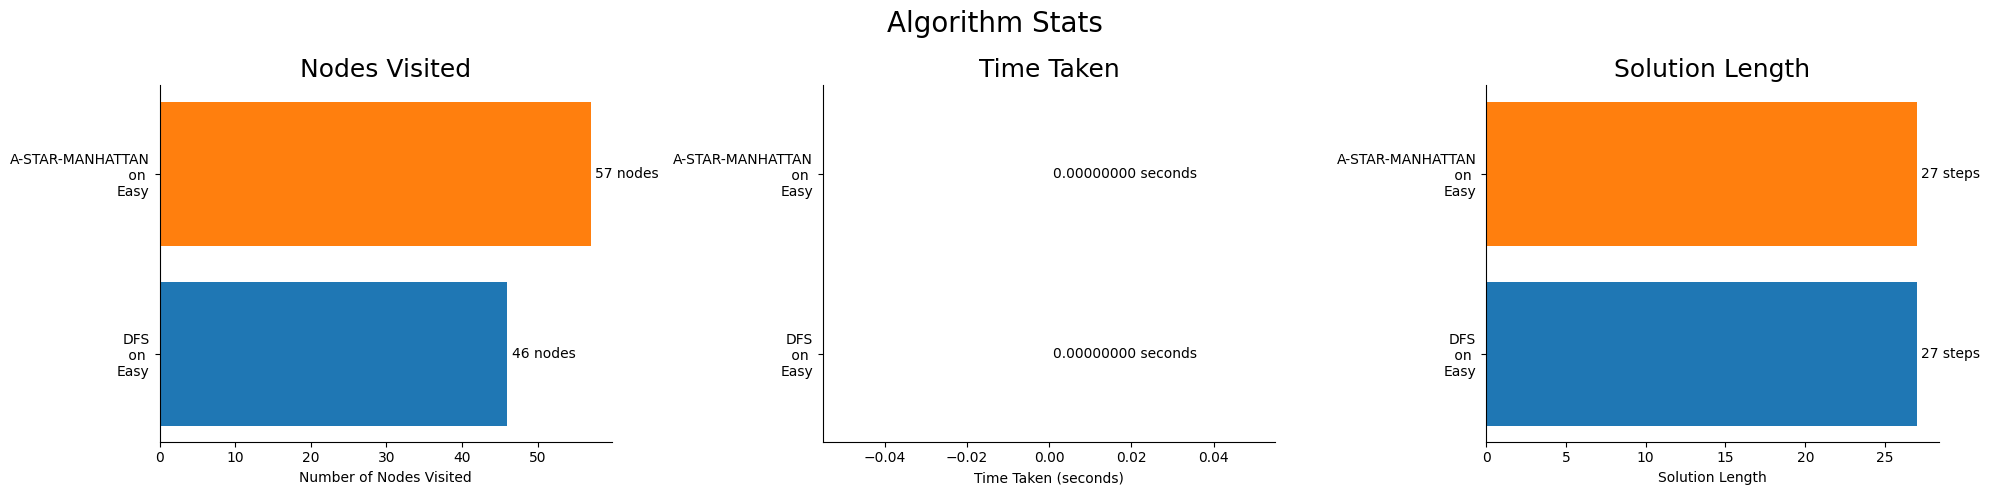

------------------- ANALYSIS ON MEDIUM -------------------


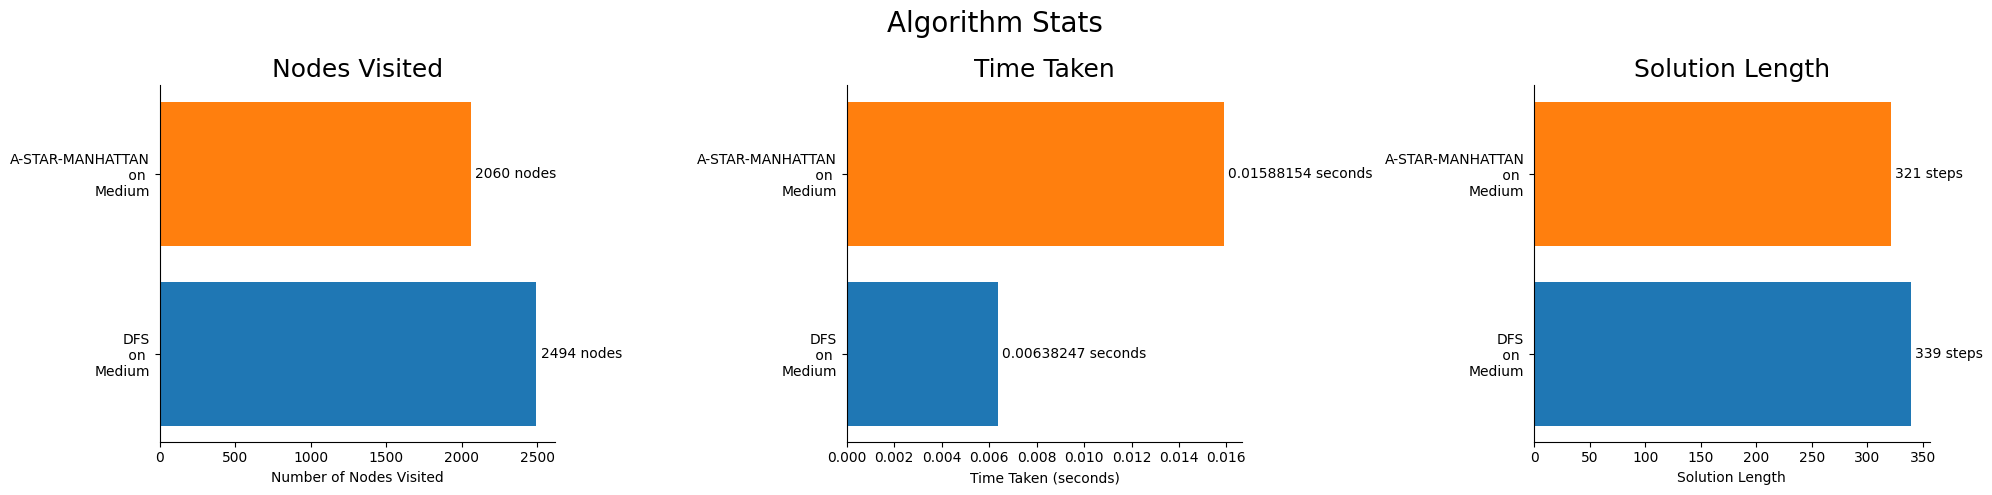

------------------- ANALYSIS ON LARGE -------------------


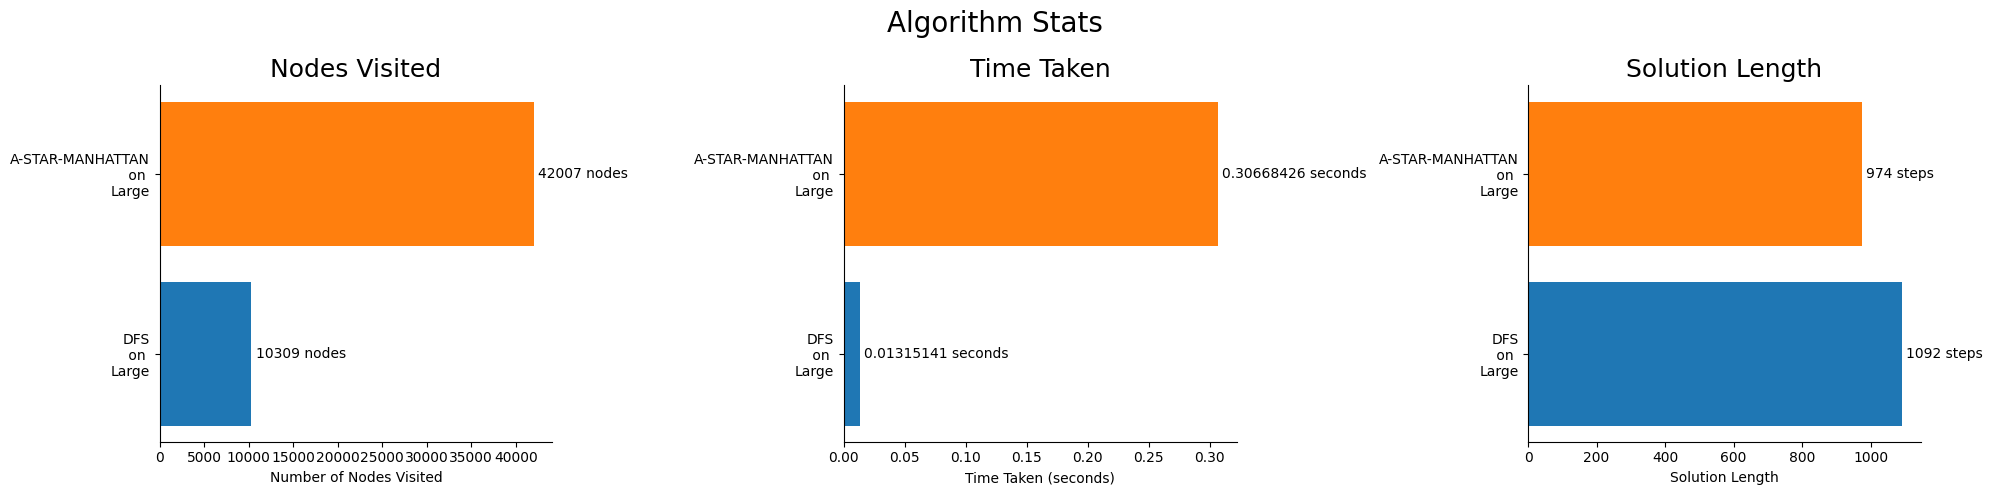

------------------- ANALYSIS ON VERY LARGE -------------------


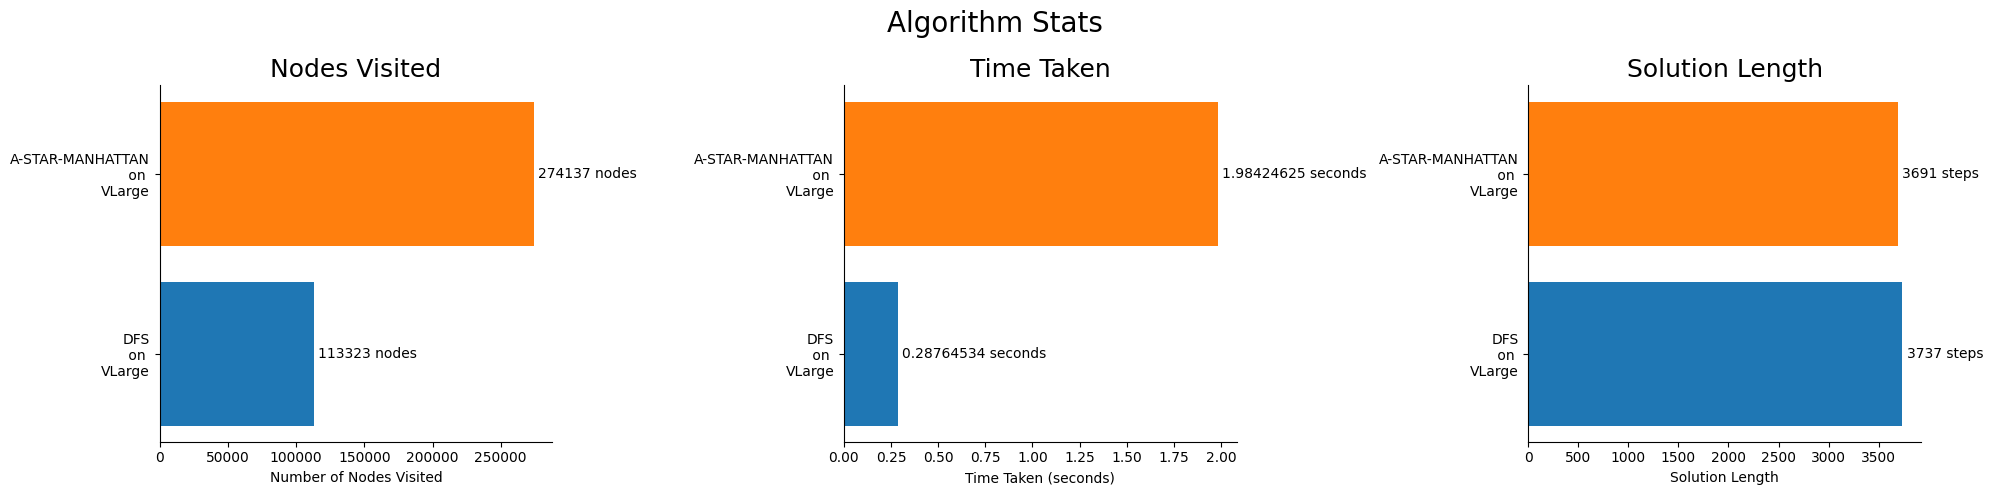

In [35]:
"""Analysis Plots for both algorithms running on easy, medium, large and vlarge maze"""

print("------------------- ANALYSIS ON EASY -------------------")
analysis_bfs_dfs_easy = Analysis([dfs_easy, astar_easy_manhattan])
analysis_bfs_dfs_easy.compare_stats()

print("------------------- ANALYSIS ON MEDIUM -------------------")
analysis_bfs_dfs_medium = Analysis([dfs_medium, astar_medium_manhattan])
analysis_bfs_dfs_medium.compare_stats()

print("------------------- ANALYSIS ON LARGE -------------------")
analysis_bfs_dfs_large = Analysis([dfs_large, astar_large_manhattan])
analysis_bfs_dfs_large.compare_stats()

print("------------------- ANALYSIS ON VERY LARGE -------------------")
analysis_bfs_dfs_vlarge = Analysis([dfs_vlarge, astar_vlarge_manhattan])
analysis_bfs_dfs_vlarge.compare_stats()

**Properties of DFS:**

- Complete? No, susceptable to loops (although not in our case, we check for visited nodes!).
- Time complexity? b^d.
- Space complexity? dmax.
- Optimality? No.


**Properties of A-Star:**

- Complete? Yes
- Time Complexity? Exponential, but reduced with a good heuristic.
- Space complexity? b^d, stores all generated nodes in memory.
- Optimality? Yes, if admissible heuristic.

**Conclusions**

- Nodes Visited: A-Star explored more nodes than DFS for all mazes, apart from Medium. This is slightly unexpected, as you'd expect a guided search to explore fewer nodes. This will be due to the maze configuration. It's worth noting here that the peformance of DFS is dependent on the ordering of the neighbours for a given node (I experiment with this later), as that determines by how much you will backtrack. If the neighbour order was reversed in DFS, A-Star would explore fewer nodes than DFS. A-Star is not dependent on the ordering as it uses a priority queue.

- Time Taken: For most purposes, time taken is a function of the nodes explored, so it's unsurprising that A* takes longer, as well as considering the fact that there is the cost to evaluating each node. This overhead can be seen with the medium nodes, were even though fewer nodes were visited, there was still a longer time taken to find the solution.

- Steps in Solution: This is where A-Star shines. In all cases A-Star found the most optimal solution, due to its admissible heuristic of manhattan distances. Only in the first case was DFS able to find the most optimal solution, and this just happened to be the case due to the shape of the maze.





# **Further Experimentation**

I will explore 2 more algorithms: BFS and Greedy search, and do some additional experimentation at the end...

#### **Breadth First Search (BFS):**

The core idea is to complete one level of nodes before moving on to the next. Very similar to DFS, except it uses a queue instead of a stack.

**Steps are as follows:**
1. Initialise a **queue** with the start node.
2. While the queue is not empty:
    1. Pop the first element from the queue, call it the current node
    2. If current node hasn't been visited:
        1. Mark the current node as visited
        2. If the current node is the goal node:
            - Construct the solution path using the parents of each node and stop searching.
        3. Add each unvisited neighbour to the queue 

**Motivation:**
It's comparable with both DFS and A-Star.
- DFS vs BFS highlights how a simple change in data structure can change an algorithm. DFS uses a stack, while BFS uses a queue. Therefore, one can easily adapt the DFS algorithm to act as a BFS.
- A-Star vs BFS both are optimal (provided A-Star has an admissable heuristic) so it will be interesting to compare their stats, which one peforms better but still outputs an optimal solution. My assumption is A-Star will have better peformance due to the fact it is an informed search, meaning it will go in more promising directions, rather than a systematic unguided search like BFS.

In [36]:
"""BFS implementation (content largely taken from DFS implementation)"""
class BFS(Algorithm):
    def __init__(self, filename):
        super().__init__(filename)

        self.name = "BFS"
        print("ALGORITHM: " + self.name)
        start_time = time.time()

        source = self.maze.startnode
        goal = self.maze.goalnode
        graph = self.maze.adjacency_list

        parent = self.parent

        # Create a queue for BFS (FIFO)
        queue = [source]

        # Add source node to parent dictionary
        parent[source] = None
        
        # Traverse the graph using DFS
        while queue:
            # Pop the first from the queue (FIFO)
            current = queue.pop(0)
            # Add current node to the visited set
            if current not in self.visited:
                self.visited.add(current)

                # If the current node is the goal, reconstruct and set the solution path
                if current == goal:
                    path = [current]
                    while path[-1] != source:
                        path.append(parent[path[-1]])
                    path.reverse()
                    self.solution = path
                    self.steps = len(path)
                    self.time_taken = time.time() - start_time
                    return
                # Add the neighbours of the current node to the stack (provided they havent been visited)
                for neighbour in graph[current]:
                    if neighbour not in self.visited:
                        parent[neighbour] = current
                        queue.append(neighbour)

        return

In [37]:
"""Running BFS on the 4 mazes"""

bfs_easy = BFS("mazes/maze-Easy.txt")
bfs_easy.stats()

bfs_medium = BFS("mazes/maze-Medium.txt")
bfs_medium.stats()
# bfs_medium.maze_img()

bfs_large = BFS("mazes/maze-Large.txt")
bfs_large.stats()
# bfs_large.maze_img()

bfs_vlarge = BFS("mazes/maze-VLarge.txt")
bfs_vlarge.stats()
# bfs_vlarge.maze_img()

ALGORITHM: BFS
MAZE: Easy
TIME TAKEN TO FIND SOLUTION: 0.0 seconds
NUMBER OF NODES VISITED: 78
NUMBER OF STEPS IN SOLUTION: 27


ALGORITHM: BFS
MAZE: Medium
TIME TAKEN TO FIND SOLUTION: 0.010028600692749023 seconds
NUMBER OF NODES VISITED: 8478
NUMBER OF STEPS IN SOLUTION: 321


ALGORITHM: BFS
MAZE: Large
TIME TAKEN TO FIND SOLUTION: 0.1254875659942627 seconds
NUMBER OF NODES VISITED: 82010
NUMBER OF STEPS IN SOLUTION: 974


ALGORITHM: BFS
MAZE: VLarge
TIME TAKEN TO FIND SOLUTION: 1.5157005786895752 seconds
NUMBER OF NODES VISITED: 796576
NUMBER OF STEPS IN SOLUTION: 3691




#### **Greedy Search:**

The core idea is to evaluate nodes only by the estimated remaining cheapest cost to the goal node using a hueristic. Very similar to A-Star.

Evalutation function **f(n) = h(n)**
- **h(n)** Estimated remaining cheapest cost to the goal node, from node n

**Steps are as follows:**

1. Initialise a priority queue with the start node and its evalutation.
2. While the queue is not empty:
    1. Pop the highest-priority node from the queue, call it the current node
    2. If the current node hasn't been visited
        1. Mark the node as visited
        2. If the current node is the goal node:
            - Construct the solution path using the parents of each node and stop searching.
        3. For each unvisited neighbour:
            - Evaluate it using **f(n) = h(n)**
            - Add it to the priority queue


**Motivation:**
Again, It's comparable with both DFS and A-Star. Personally I'd call it the 'middle child' of the two!
- Both DFS and Greedy are suboptimal, designed to be low-memory use methods.
- A-Star search and greedy search are both best-first search algorithms, meaning they both have heuristic that guides the algorithm, although Greedy is suboptimal while A-Star is optimal. Is a loss in peformance worth the gain in optimality?

In [38]:
"""Greedy Search implementation, manhattan heuristic (largely from A-Star implementation)"""
class GREEDY(Algorithm):
    def __init__(self, filename):
        super().__init__(filename)

        self.name = "GREEDY-SEARCH-MANHATTAN"
        print("ALGORITHM: " + self.name)

        start_time = time.time()
        source = self.maze.startnode
        goal = self.maze.goalnode
        graph = self.maze.adjacency_list
        parent = self.parent

        # Create a priority queue, with the node and its evaluation
        queue = [(self.maze.manhattan_distance(source), source)]

        # Set the source's parent to None
        parent[source] = None

        while queue:
            # Pop the node with the highest priority from the queue (smallest evaluation)
            _, current = heapq.heappop(queue)
            if current not in self.visited:
                self.visited.add(current)

                # If the current node is the goal, reconstruct and set the path
                if current == goal:
                    path = [current]
                    while path[-1] != source:
                        path.append(parent[path[-1]])
                    path.reverse()
                    self.solution = path
                    self.steps = len(path)
                    self.time_taken = time.time() - start_time
                    return

                # Expand the current node and add its neighbours to the queue
                for neighbour in graph[current]:
                    # If the neighbour hasn't been visited before
                    if neighbour not in self.visited:
                        # Evaluation Function f(n) = h(n)
                        evaluation = self.maze.manhattan_distance(neighbour)
                        parent[neighbour] = current
                        heapq.heappush(queue, (evaluation, neighbour))
        return

In [39]:
"""Running Greedy Search on the 4 mazes"""
greedy_easy_manhattan = GREEDY("mazes/maze-Easy.txt")
greedy_easy_manhattan.stats()
# greedy_easy.maze_img()

greedy_medium_manhattan = GREEDY("mazes/maze-Medium.txt")
greedy_medium_manhattan.stats()
# greedy_medium.maze_img()

greedy_large_manhattan = GREEDY("mazes/maze-Large.txt")
greedy_large_manhattan.stats()
# greedy_large.maze_img()

greedy_vlarge_manhattan = GREEDY("mazes/maze-VLarge.txt")
greedy_vlarge_manhattan.stats()
# greedy_vlarge.maze_img()

ALGORITHM: GREEDY-SEARCH-MANHATTAN
MAZE: Easy
TIME TAKEN TO FIND SOLUTION: 0.0 seconds
NUMBER OF NODES VISITED: 35
NUMBER OF STEPS IN SOLUTION: 27


ALGORITHM: GREEDY-SEARCH-MANHATTAN
MAZE: Medium
TIME TAKEN TO FIND SOLUTION: 0.0019969940185546875 seconds
NUMBER OF NODES VISITED: 486
NUMBER OF STEPS IN SOLUTION: 321


ALGORITHM: GREEDY-SEARCH-MANHATTAN
MAZE: Large
TIME TAKEN TO FIND SOLUTION: 0.03866386413574219 seconds
NUMBER OF NODES VISITED: 14407
NUMBER OF STEPS IN SOLUTION: 1122


ALGORITHM: GREEDY-SEARCH-MANHATTAN
MAZE: VLarge
TIME TAKEN TO FIND SOLUTION: 0.2319812774658203 seconds
NUMBER OF NODES VISITED: 103906
NUMBER OF STEPS IN SOLUTION: 3699




### **Now let's use our analysis class!**

------------------- ANALYSIS ON EASY -------------------


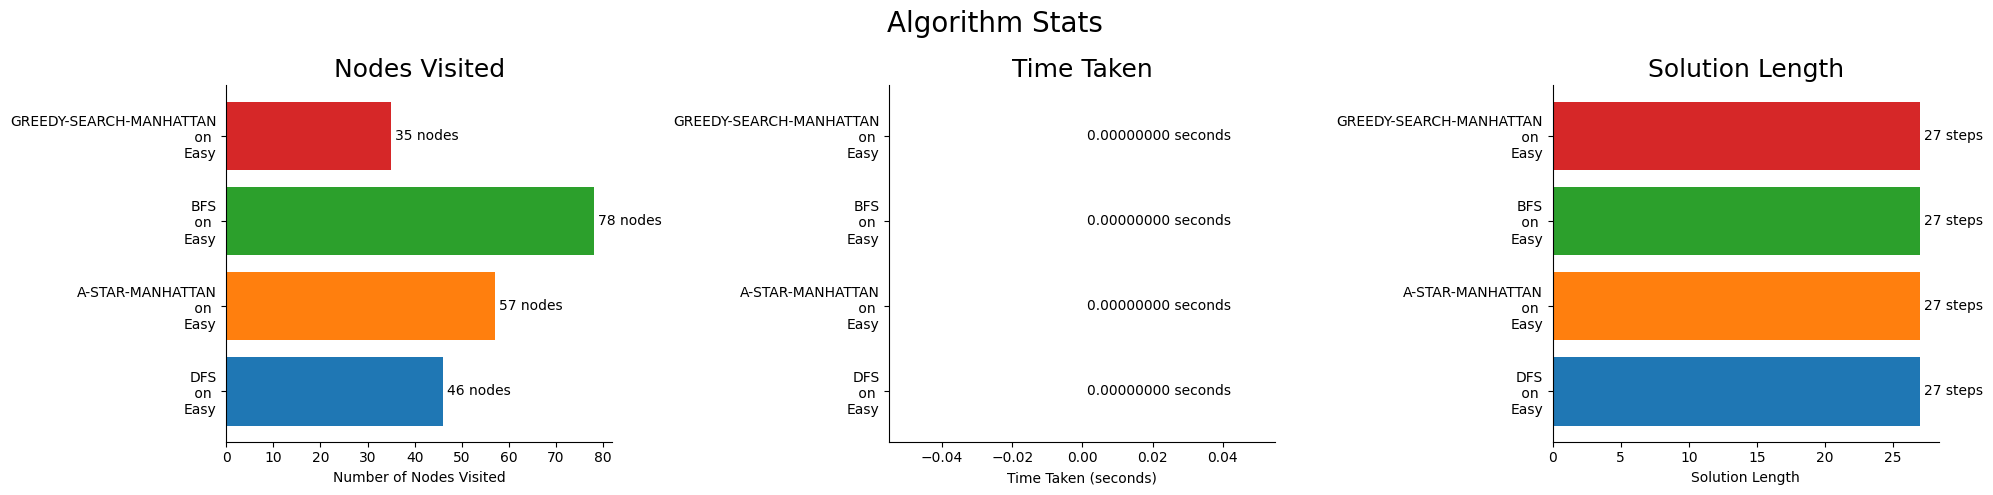

------------------- ANALYSIS ON MEDIUM -------------------


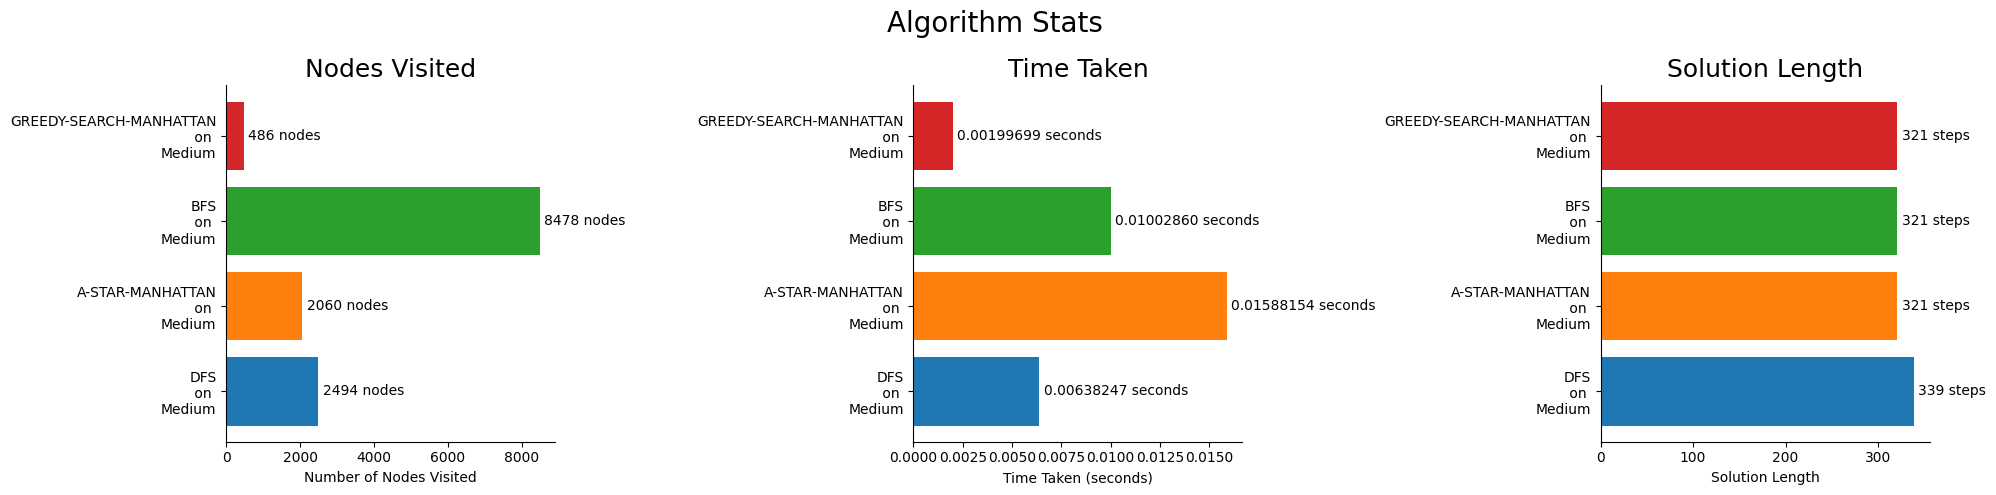

------------------- ANALYSIS ON LARGE -------------------


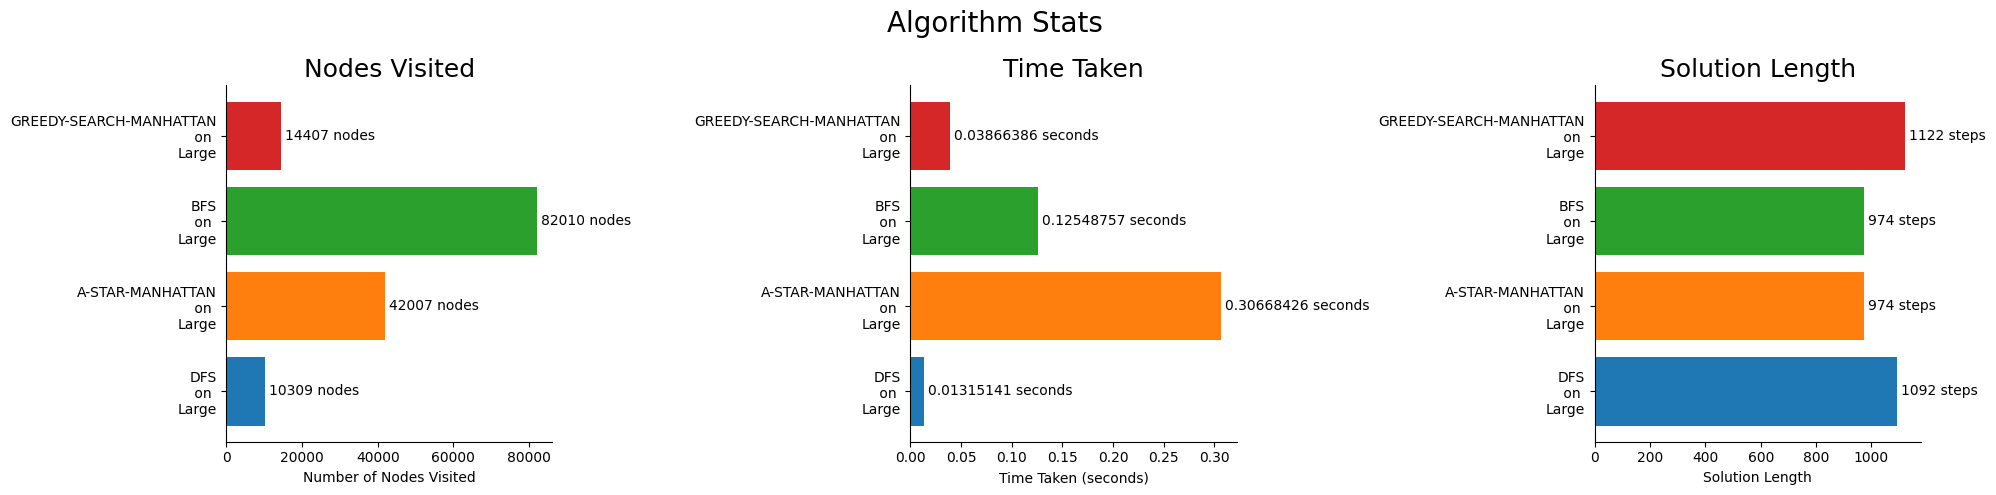

------------------- ANALYSIS ON VERY LARGE -------------------


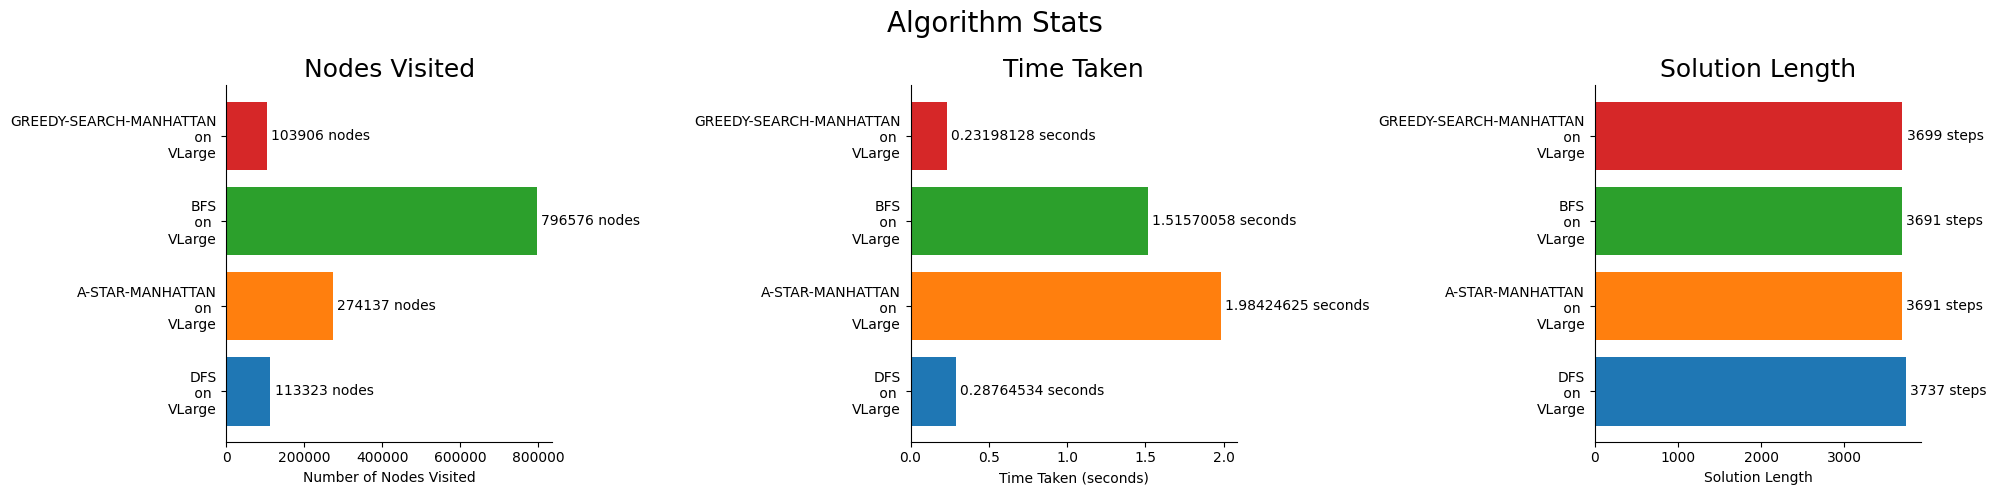

In [40]:
"""Stat comparison graphs of all algorithms on all mazes"""
print("------------------- ANALYSIS ON EASY -------------------")
analysis_all_easy = Analysis([dfs_easy, astar_easy_manhattan, bfs_easy, greedy_easy_manhattan])
analysis_all_easy.compare_stats()

print("------------------- ANALYSIS ON MEDIUM -------------------")
analysis_all_medium = Analysis([dfs_medium, astar_medium_manhattan, bfs_medium, greedy_medium_manhattan])
analysis_all_medium.compare_stats()

print("------------------- ANALYSIS ON LARGE -------------------")
analysis_all_large = Analysis([dfs_large, astar_large_manhattan, bfs_large, greedy_large_manhattan])
analysis_all_large.compare_stats()

print("------------------- ANALYSIS ON VERY LARGE -------------------")
analysis_all_vlarge = Analysis([dfs_vlarge, astar_vlarge_manhattan, bfs_vlarge, greedy_vlarge_manhattan])
analysis_all_vlarge.compare_stats()

### Conclusions...

**Nodes Visited**
- It seems BFS consistently searches the most nodes, which is to be expected as it explores all neighbours before going deeper, and does this for almost every node.
- Greedy Search peformed surprisingly well, searching the fewest amount of nodes on all mazes apart from large maze. Had similar peformance to DFS
- A* was in the middle between BFS and DFS, which is good considering the fact that it outputs an optimal solution.

**Time Taken**
- A* Search took surprisingly long. I think the bulk of this comes from evaluating nodes. Take vlarge for example: it explores under half the nodes of BFS, but takes .5 seconds longer to find the most optimal solution!
- DFS remains really quick, although on medium (must be due to the layout of the maze), greedy search managed to complete it almost instantly.

**Solution Length**
- As expected, BFS and A* both share the most optimal number of steps for the solution.
- I'd say greedy search tended to be better than DFS (excluding large), as greedy search is an informed search after all.

# **Bonus Stuff...**

### **Hidden factor that affects runtime and nodes explored..**

The way you choose to order neighbours when constructing an adjacency list can be arbritrary. 

My implementation had *loose* reasoning in the hopes of improving run-time:
- The maze algorithm probably goes down more than up/left/right, so add that to the neighbours first
- The maze algorithm probably goes right more than up/left
- The maze algorithm probably goes left more than up

But, theoretically, this ordering could be completely different - so I experimented with that to see how it would affect nodes visited with DFS (and BFS).

**Here are DFS then BFS with each node's neighbours list reversed**

In [41]:
"""1.2 DFS Algorithm Implementation with reversed neighbours list"""
class DFS(Algorithm):
    def __init__(self, filename):
        super().__init__(filename)

        self.name = "DFS-REVERSED-NEIGHBOURS"
        print("ALGORITHM: " + self.name)
        start_time = time.time()

        source = self.maze.startnode
        goal = self.maze.goalnode
        graph = self.maze.adjacency_list

        parent = self.parent

        # Create a stack for DFS (LIFO)
        stack = [source]

        # Add source node to parent dictionary
        parent[source] = None
        
        # Traverse the graph using DFS
        while stack:
            # Pop the next node from the stack (LIFO)
            current = stack.pop()
            if current not in self.visited:
            # Add current node to the visited set
                self.visited.add(current)
                # If the current node is the goal, reconstruct and set the solution path
                if current == goal:
                    path = [current]
                    while path[-1] != source:
                        path.append(parent[path[-1]])
                    path.reverse()
                    self.solution = path
                    self.steps = len(path)
                    self.time_taken = time.time() - start_time
                    return
                # Add the neighbours of the current node to the stack (provided they havent been visited)
                for neighbour in reversed(graph[current]):
                    if neighbour not in self.visited:
                        parent[neighbour] = current
                        stack.append(neighbour)

        return

In [42]:
"""1.2 Running DFS Reversed Neighbours on the 4 mazes"""

dfs_rev_neb_easy = DFS("mazes/maze-Easy.txt")
dfs_rev_neb_easy.stats()
# dfs_rev_neb_easy.maze_img()

dfs_rev_neb_medium = DFS("mazes/maze-Medium.txt")
dfs_rev_neb_medium.stats()
# dfs_rev_neb_medium.maze_img()

dfs_rev_neb_large = DFS("mazes/maze-Large.txt")
dfs_rev_neb_large.stats()
# dfs_rev_neb_large.maze_img()

dfs_rev_neb_vlarge = DFS("mazes/maze-VLarge.txt")
dfs_rev_neb_vlarge.stats()
# dfs_rev_neb_vlarge.maze_img()

ALGORITHM: DFS-REVERSED-NEIGHBOURS
MAZE: Easy
TIME TAKEN TO FIND SOLUTION: 0.0 seconds
NUMBER OF NODES VISITED: 78
NUMBER OF STEPS IN SOLUTION: 27


ALGORITHM: DFS-REVERSED-NEIGHBOURS
MAZE: Medium
TIME TAKEN TO FIND SOLUTION: 0.011379003524780273 seconds
NUMBER OF NODES VISITED: 8411
NUMBER OF STEPS IN SOLUTION: 737


ALGORITHM: DFS-REVERSED-NEIGHBOURS
MAZE: Large
TIME TAKEN TO FIND SOLUTION: 0.10803699493408203 seconds
NUMBER OF NODES VISITED: 72298
NUMBER OF STEPS IN SOLUTION: 1050


ALGORITHM: DFS-REVERSED-NEIGHBOURS
MAZE: VLarge
TIME TAKEN TO FIND SOLUTION: 2.222083330154419 seconds
NUMBER OF NODES VISITED: 778769
NUMBER OF STEPS IN SOLUTION: 6131




In [43]:
"""BFS implementation with reversed neighbours list"""
class BFS(Algorithm):
    def __init__(self, filename):
        super().__init__(filename)

        self.name = "BFS-REVERSED-NEIGHBOURS"
        print("ALGORITHM: " + self.name)
        start_time = time.time()

        source = self.maze.startnode
        goal = self.maze.goalnode
        graph = self.maze.adjacency_list

        parent = self.parent

        # Create a queue for BFS (FIFO)
        queue = [source]

        # Add source node to parent dictionary
        parent[source] = None
        
        # Traverse the graph using DFS
        while queue:
            # Pop the first from the queue (FIFO)
            current = queue.pop(0)
            # Add current node to the visited set
            if current not in self.visited:
                self.visited.add(current)

                # If the current node is the goal, reconstruct and set the solution path
                if current == goal:
                    path = [current]
                    while path[-1] != source:
                        path.append(parent[path[-1]])
                    path.reverse()
                    self.solution = path
                    self.steps = len(path)
                    self.time_taken = time.time() - start_time
                    return
                # Add the neighbours of the current node to the stack (provided they havent been visited)
                for neighbour in reversed(graph[current]):
                    if neighbour not in self.visited:
                        parent[neighbour] = current
                        queue.append(neighbour)

        return

In [44]:
"""Running BFS Reversed Neighbours on the 4 mazes"""

bfs_rev_neb_easy = BFS("mazes/maze-Easy.txt")
bfs_rev_neb_easy.stats()

bfs_rev_neb_medium = BFS("mazes/maze-Medium.txt")
bfs_rev_neb_medium.stats()

bfs_rev_neb_large = BFS("mazes/maze-Large.txt")
bfs_rev_neb_large.stats()

bfs_rev_neb_vlarge = BFS("mazes/maze-VLarge.txt")
bfs_rev_neb_vlarge.stats()

ALGORITHM: BFS-REVERSED-NEIGHBOURS
MAZE: Easy
TIME TAKEN TO FIND SOLUTION: 0.000993967056274414 seconds
NUMBER OF NODES VISITED: 77
NUMBER OF STEPS IN SOLUTION: 27


ALGORITHM: BFS-REVERSED-NEIGHBOURS
MAZE: Medium
TIME TAKEN TO FIND SOLUTION: 0.010999679565429688 seconds
NUMBER OF NODES VISITED: 8448
NUMBER OF STEPS IN SOLUTION: 321


ALGORITHM: BFS-REVERSED-NEIGHBOURS
MAZE: Large
TIME TAKEN TO FIND SOLUTION: 0.1282966136932373 seconds
NUMBER OF NODES VISITED: 81991
NUMBER OF STEPS IN SOLUTION: 974


ALGORITHM: BFS-REVERSED-NEIGHBOURS
MAZE: VLarge
TIME TAKEN TO FIND SOLUTION: 5.138556718826294 seconds
NUMBER OF NODES VISITED: 796211
NUMBER OF STEPS IN SOLUTION: 3691




### **DFS vs DFS with neighbour list reversed**

------------------- ANALYSIS ON EASY -------------------


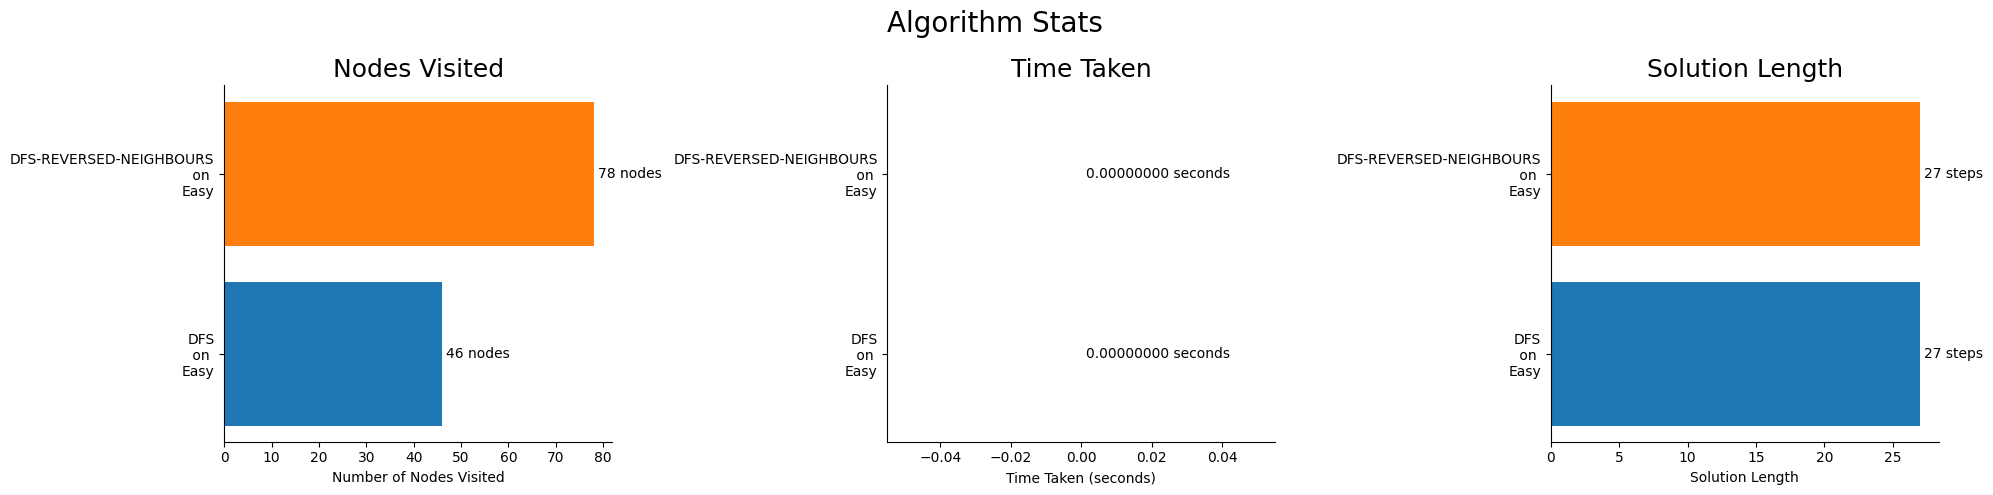

------------------- ANALYSIS ON MEDIUM -------------------


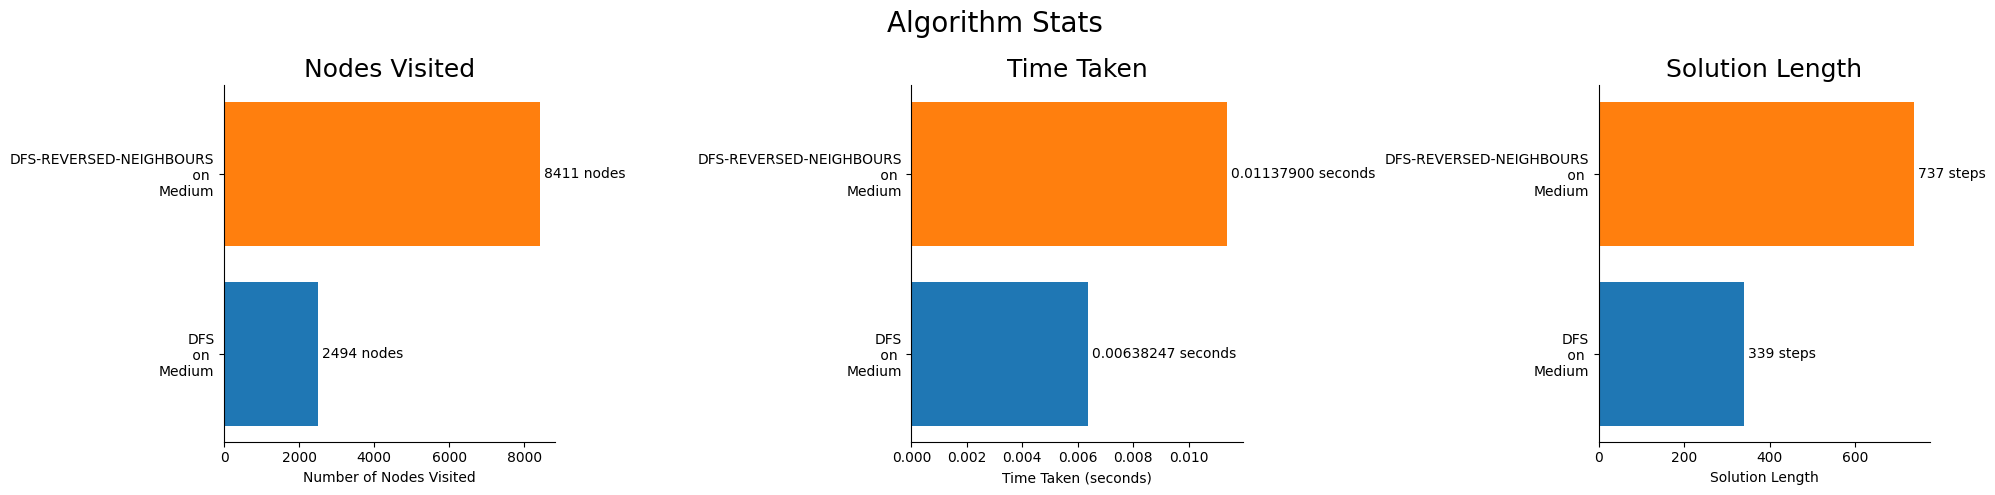

------------------- ANALYSIS ON LARGE -------------------


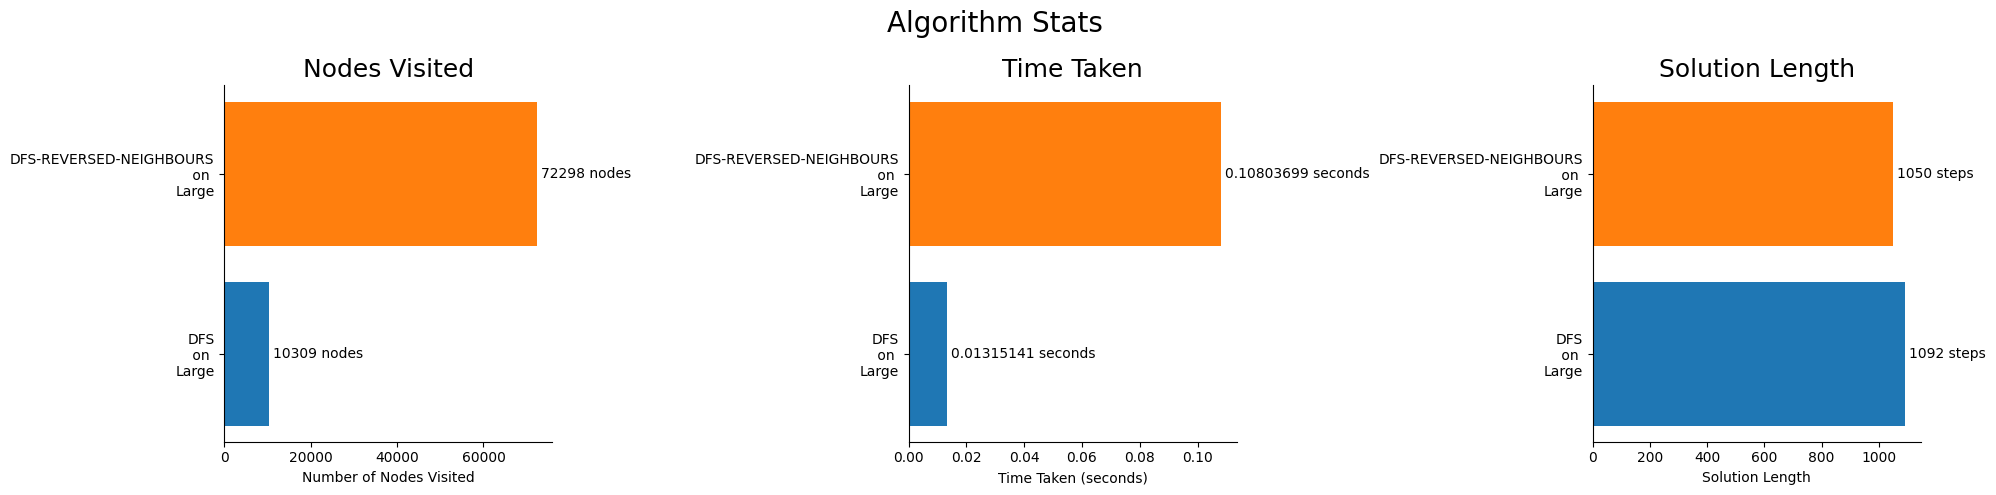

------------------- ANALYSIS ON VERY LARGE -------------------


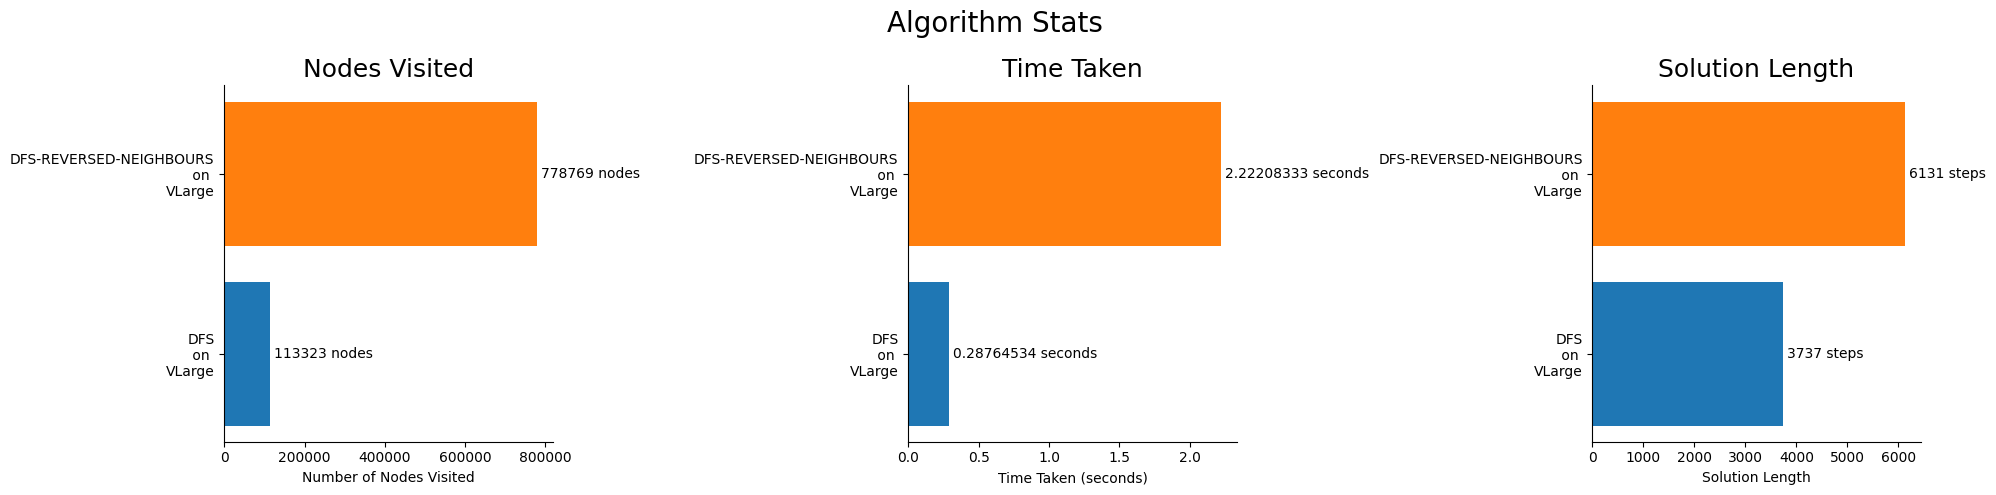

In [45]:
"""Stat comparison plots of DFS and DFS with reversed neighbours list on all mazes"""
print("------------------- ANALYSIS ON EASY -------------------")
analysis_dfs_easy = Analysis([dfs_easy, dfs_rev_neb_easy])
analysis_dfs_easy.compare_stats()

print("------------------- ANALYSIS ON MEDIUM -------------------")
analysis_dfs_medium = Analysis([dfs_medium, dfs_rev_neb_medium])
analysis_dfs_medium.compare_stats()

print("------------------- ANALYSIS ON LARGE -------------------")
analysis_dfs_large = Analysis([dfs_large, dfs_rev_neb_large])
analysis_dfs_large.compare_stats()

print("------------------- ANALYSIS ON VERY LARGE -------------------")
analysis_dfs_vlarge = Analysis([dfs_vlarge, dfs_rev_neb_vlarge])
analysis_dfs_vlarge.compare_stats()



What a difference! From this, I'd like to say that my loose reasoning was successful in making the algorithm run more efficiently.

With the reversed neighbours, DFS adds the upward node to the stack first meaning it will be explored first and, more often than not, this node won't lead to the solution, which will lead to more backtracking.

Between the two variations, larger the maze, the larger the gap in nodes visted and the larger the gap in run time.

It is interesting and worth noting that on the large maze, the number of nodes visited was much longer, but the solution was shorter!

### **BFS vs BFS with neighbour list reversed**

------------------- ANALYSIS ON EASY -------------------


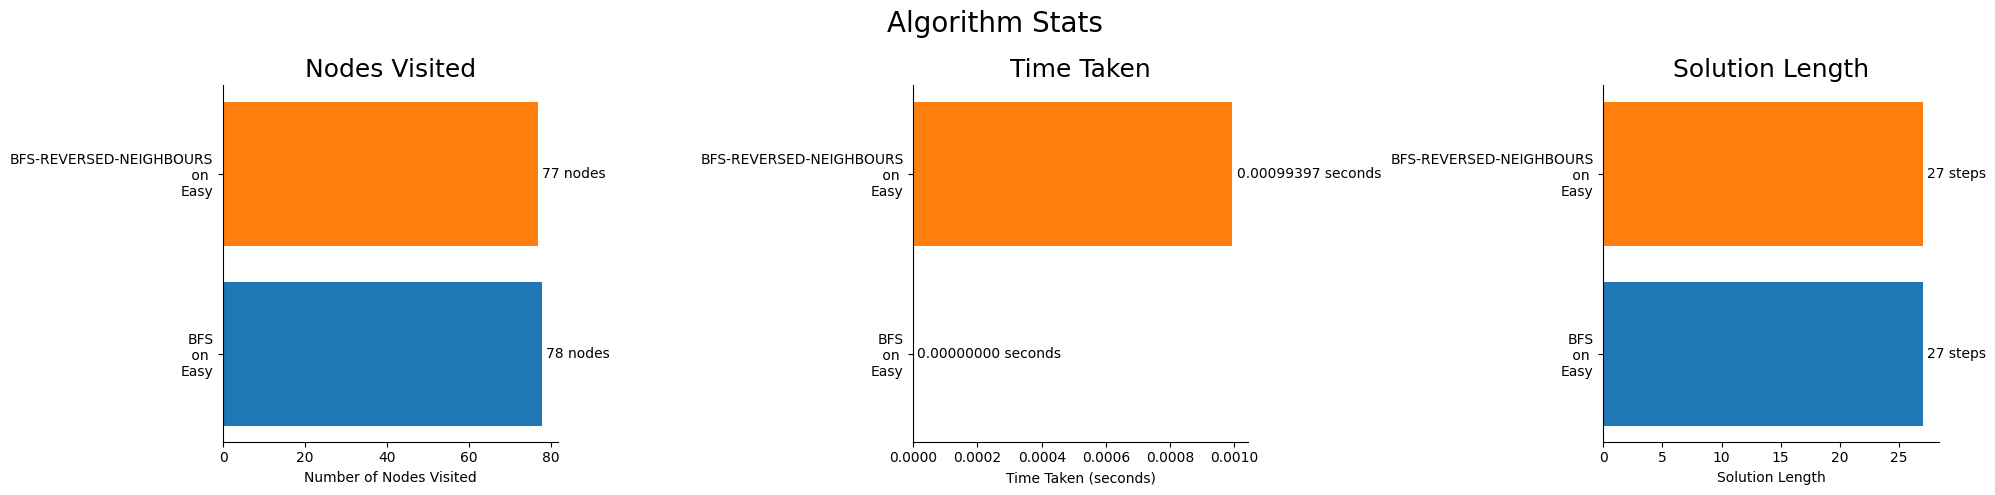

------------------- ANALYSIS ON MEDIUM -------------------


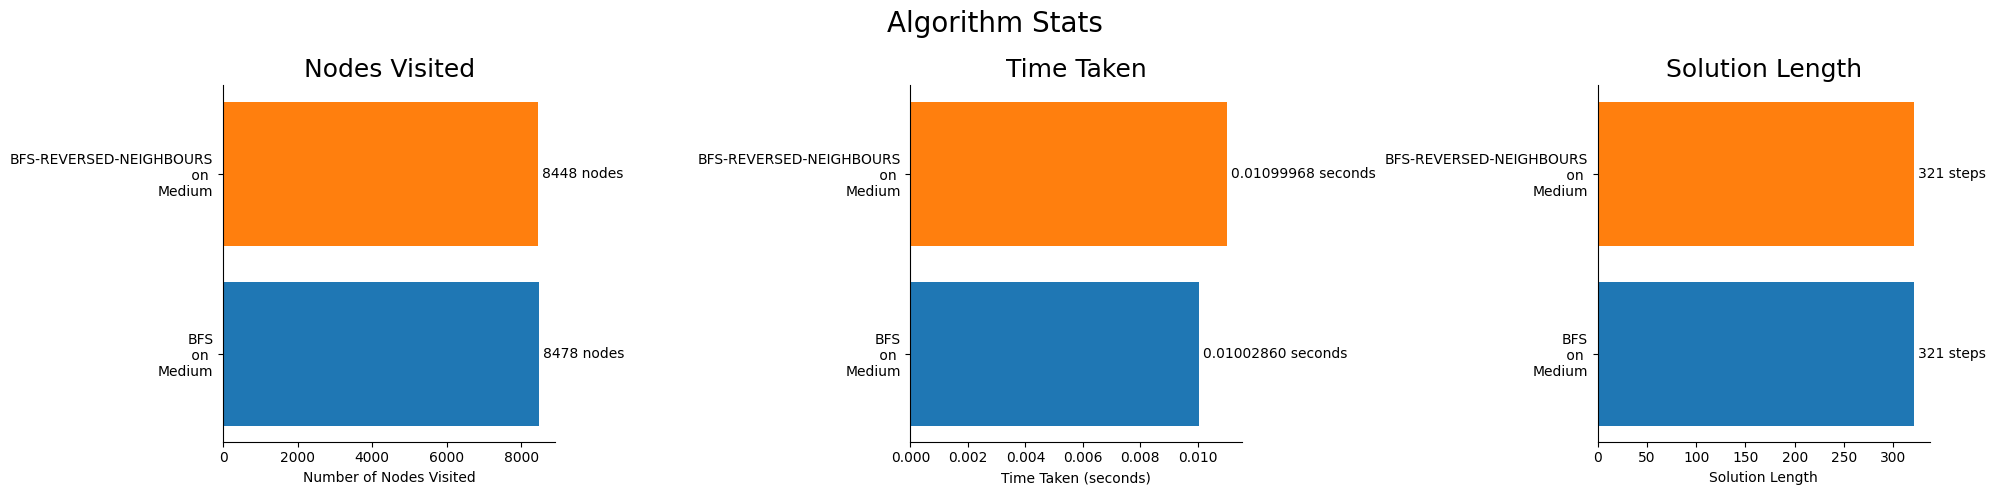

------------------- ANALYSIS ON LARGE -------------------


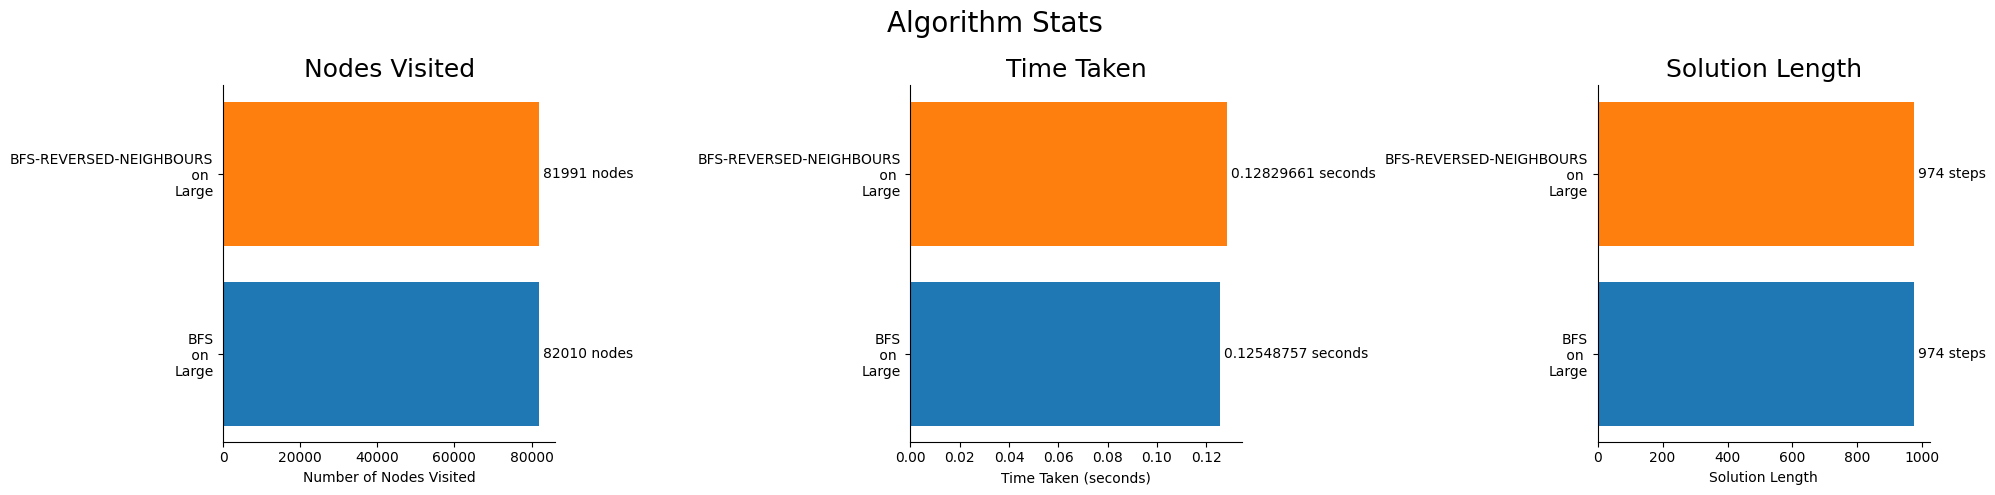

------------------- ANALYSIS ON VERY LARGE -------------------


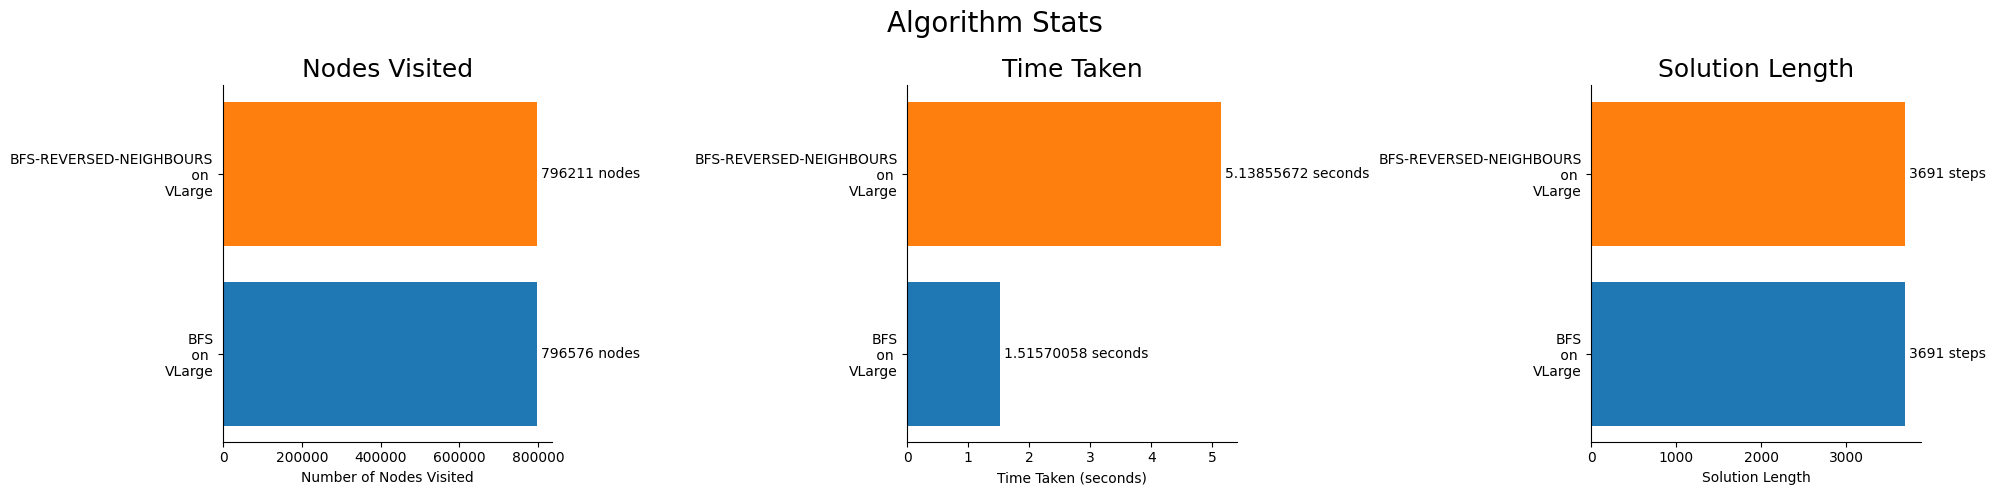

In [46]:
"""Stat comparison graphs of BFS and BFS with reversed neighbours list on all mazes"""
print("------------------- ANALYSIS ON EASY -------------------")
analysis_bfs_easy = Analysis([bfs_easy, bfs_rev_neb_easy])
analysis_bfs_easy.compare_stats()

print("------------------- ANALYSIS ON MEDIUM -------------------")
analysis_bfs_medium = Analysis([bfs_medium, bfs_rev_neb_medium])
analysis_bfs_medium.compare_stats()

print("------------------- ANALYSIS ON LARGE -------------------")
analysis_bfs_large = Analysis([bfs_large, bfs_rev_neb_large])
analysis_bfs_large.compare_stats()

print("------------------- ANALYSIS ON VERY LARGE -------------------")
analysis_bfs_vlarge = Analysis([bfs_vlarge, bfs_rev_neb_vlarge])
analysis_bfs_vlarge.compare_stats()

As seen here, BFS is less affected by the order of the nodes in the graph because it explores nodes in a breadth-first manner, meaning it will visit all nodes at the same depth before moving on to the next level. The 'going deeper' then backtracking issue isn't one that affects BFS.

### **Euclidean Distance vs Manhattan distance comparison**

As mentioned earlier, I think its worth exploring how a heuristic can change the peformance of A-Star and Greedy Search. There's not *too* much to say here, but I think its fun to have a look at!

In [47]:
"""Greedy Search implementation with Euclidean Distance"""
class GREEDY(Algorithm):
    def __init__(self, filename):
        super().__init__(filename)

        self.name = "GREEDY-SEARCH-EUCLIDEAN-DISTANCE"
        print("ALGORITHM: " + self.name)

        start_time = time.time()
        source = self.maze.startnode
        goal = self.maze.goalnode
        graph = self.maze.adjacency_list
        parent = self.parent

        # Create a priority queue, with the node and its evaluation
        queue = [(self.maze.euclidean_distance(source), source)]

        # Set the source's parent to None
        parent[source] = None

        while queue:
            # Pop the node with the highest priority from the queue (smallest evaluation)
            _, current = heapq.heappop(queue)
            if current not in self.visited:
                self.visited.add(current)

                # If the current node is the goal, reconstruct and set the path
                if current == goal:
                    path = [current]
                    while path[-1] != source:
                        path.append(parent[path[-1]])
                    path.reverse()
                    self.solution = path
                    self.steps = len(path)
                    self.time_taken = time.time() - start_time
                    return

                # Expand the current node and add its neighbours to the queue
                for neighbour in graph[current]:
                    # If the neighbour hasn't been visited before
                    if neighbour not in self.visited:
                        # Evaluation Function f(n) = h(n)
                        evaluation = self.maze.euclidean_distance(neighbour)
                        parent[neighbour] = current
                        heapq.heappush(queue, (evaluation, neighbour))
        return

In [48]:
"""Running Greedy Search on the 4 mazes"""
greedy_easy_euclidean = GREEDY("mazes/maze-Easy.txt")
greedy_easy_euclidean.stats()
# greedy_easy.maze_img()

greedy_medium_euclidean = GREEDY("mazes/maze-Medium.txt")
greedy_medium_euclidean.stats()
# greedy_medium.maze_img()

greedy_large_euclidean = GREEDY("mazes/maze-Large.txt")
greedy_large_euclidean.stats()
# greedy_large.maze_img()

greedy_vlarge_euclidean = GREEDY("mazes/maze-VLarge.txt")
greedy_vlarge_euclidean.stats()
# greedy_vlarge.maze_img()

ALGORITHM: GREEDY-SEARCH-EUCLIDEAN-DISTANCE
MAZE: Easy
TIME TAKEN TO FIND SOLUTION: 0.0 seconds
NUMBER OF NODES VISITED: 29
NUMBER OF STEPS IN SOLUTION: 27


ALGORITHM: GREEDY-SEARCH-EUCLIDEAN-DISTANCE
MAZE: Medium
TIME TAKEN TO FIND SOLUTION: 0.0020003318786621094 seconds
NUMBER OF NODES VISITED: 540
NUMBER OF STEPS IN SOLUTION: 321


ALGORITHM: GREEDY-SEARCH-EUCLIDEAN-DISTANCE
MAZE: Large
TIME TAKEN TO FIND SOLUTION: 0.034515380859375 seconds
NUMBER OF NODES VISITED: 10333
NUMBER OF STEPS IN SOLUTION: 1092


ALGORITHM: GREEDY-SEARCH-EUCLIDEAN-DISTANCE
MAZE: VLarge
TIME TAKEN TO FIND SOLUTION: 1.0168015956878662 seconds
NUMBER OF NODES VISITED: 299712
NUMBER OF STEPS IN SOLUTION: 3737




------------------- ANALYSIS ON EASY -------------------


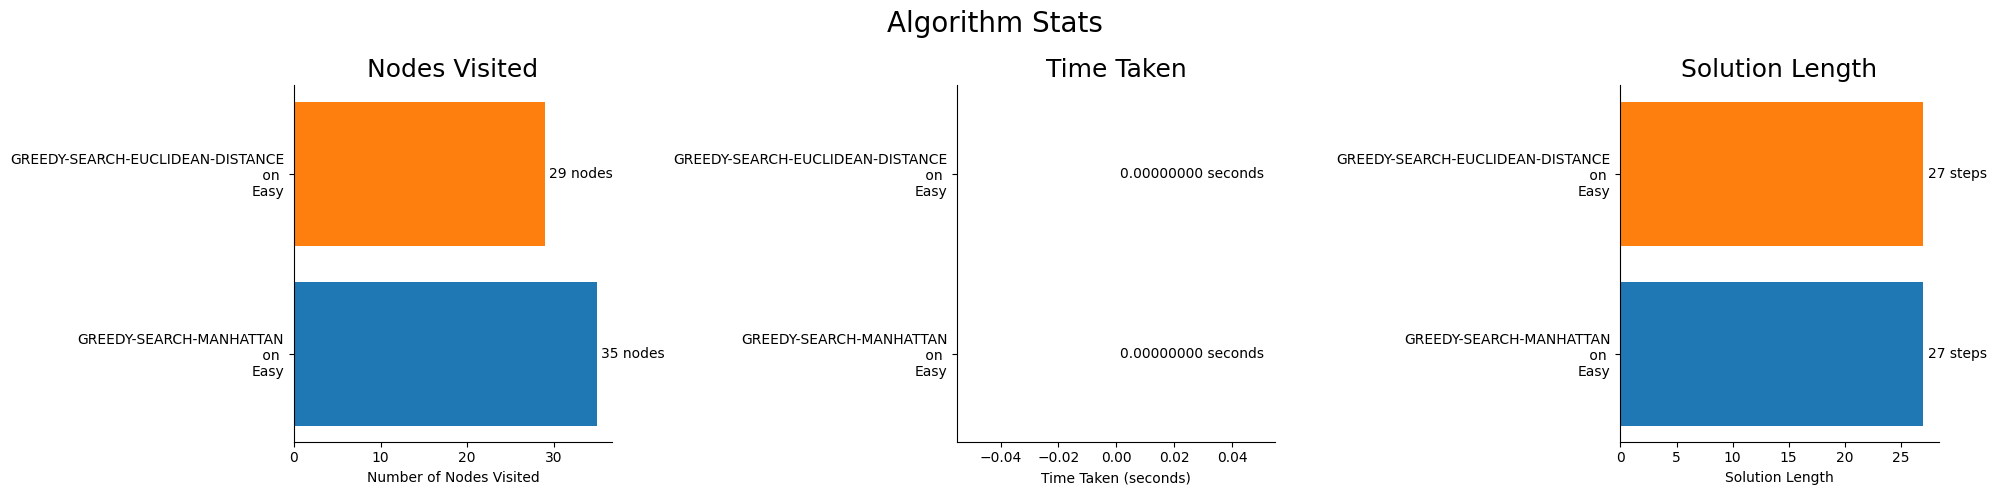

------------------- ANALYSIS ON MEDIUM -------------------


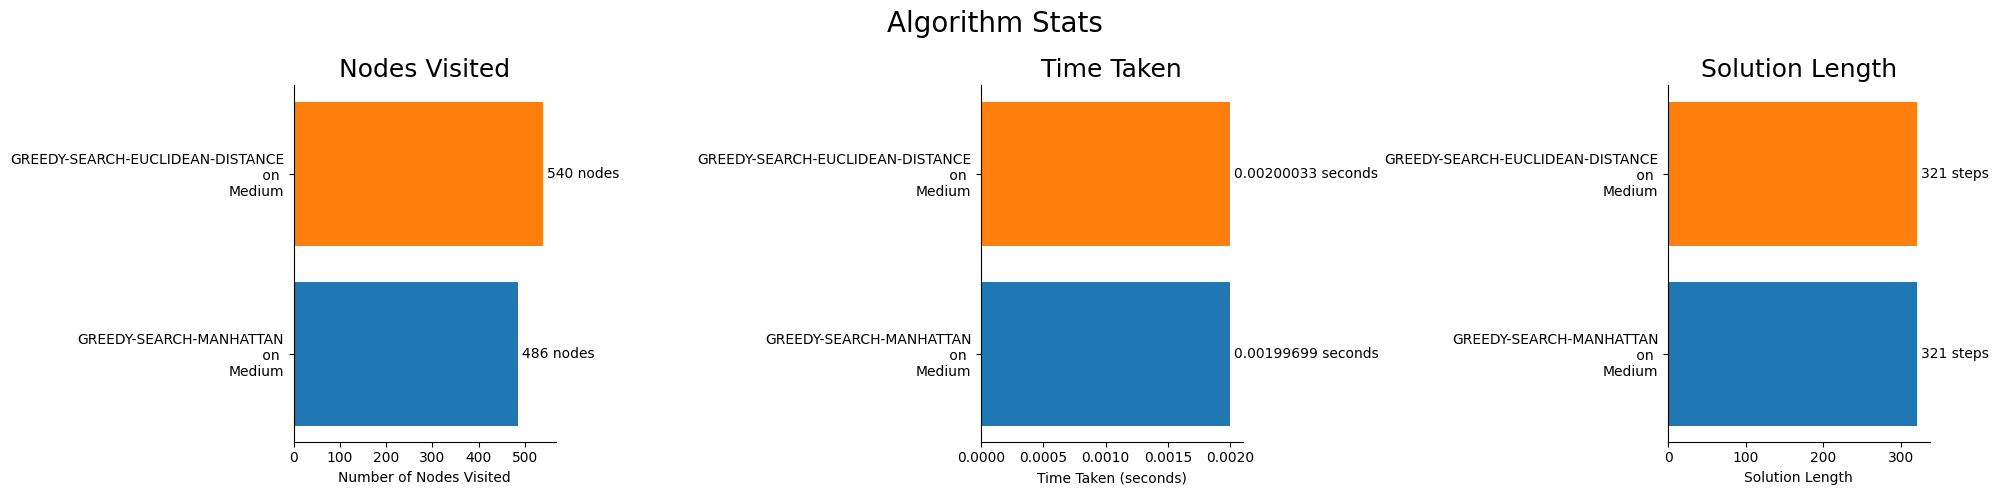

------------------- ANALYSIS ON LARGE -------------------


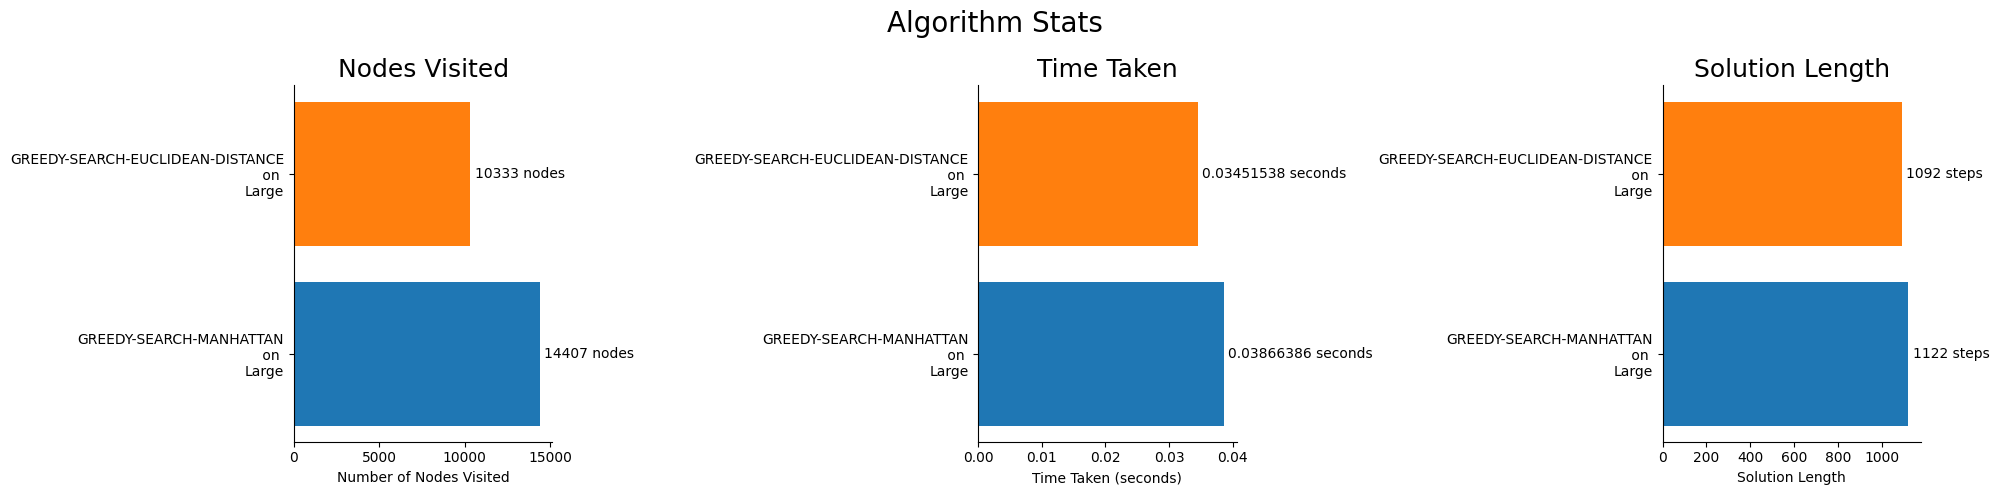

------------------- ANALYSIS ON VERY LARGE -------------------


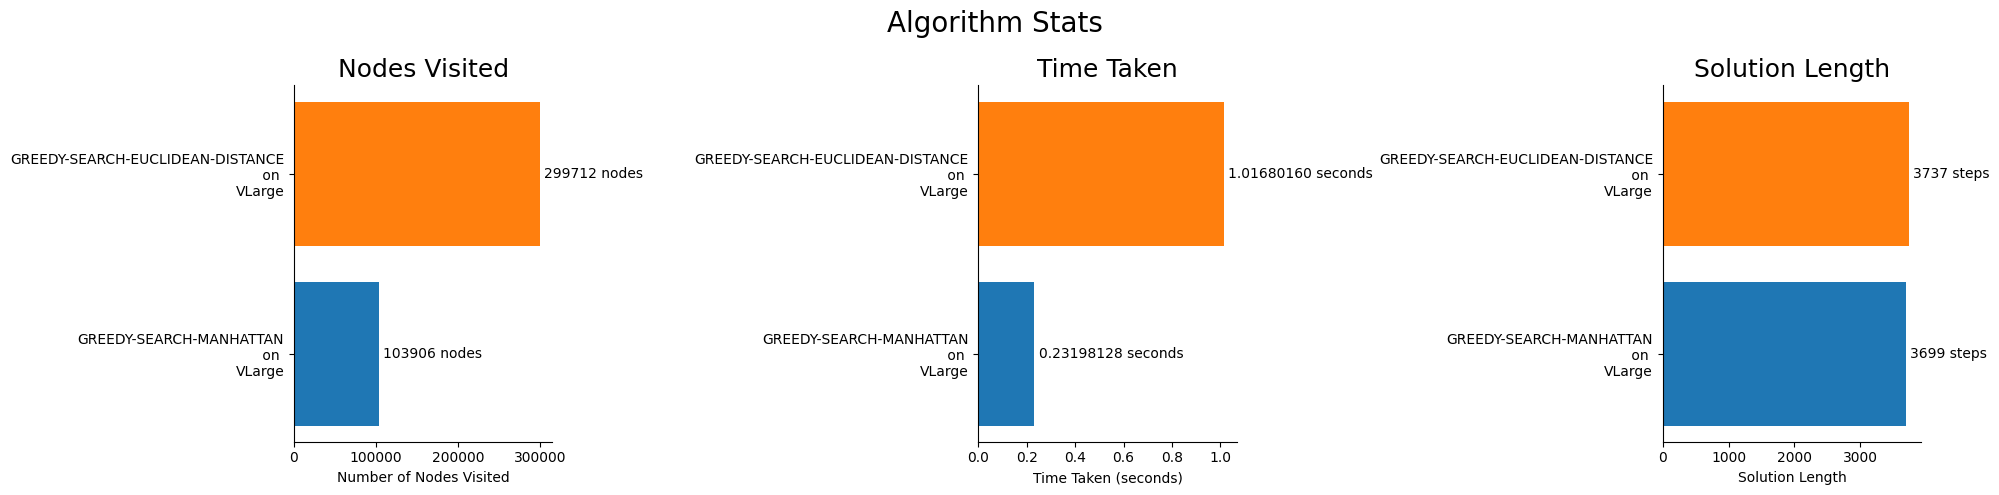

In [49]:
"""Stats of the Greedy search algorithm, Manhattan Heuristic vs Euclidean Heuristic"""

print("------------------- ANALYSIS ON EASY -------------------")
analysis_greedy_easy = Analysis([greedy_easy_manhattan, greedy_easy_euclidean])
analysis_greedy_easy.compare_stats()

print("------------------- ANALYSIS ON MEDIUM -------------------")
analysis_greedy_medium = Analysis([greedy_medium_manhattan, greedy_medium_euclidean])
analysis_greedy_medium.compare_stats()

print("------------------- ANALYSIS ON LARGE -------------------")
analysis_greedy_large = Analysis([greedy_large_manhattan, greedy_large_euclidean])
analysis_greedy_large.compare_stats()

print("------------------- ANALYSIS ON VERY LARGE -------------------")
analysis_greedy_vlarge = Analysis([greedy_vlarge_manhattan, greedy_vlarge_euclidean])
analysis_greedy_vlarge.compare_stats()

In [50]:
"""1.3 A-Star Search Algorithm Implementation, Euclidean Distance (as a class)"""
class ASTAR(Algorithm):
    def __init__(self, filename):
        super().__init__(filename)

        self.name = "A-STAR-EUCLIDEAN"
        print("ALGORITHM: " + self.name)
        
        start_time = time.time()
        source = self.maze.startnode

        goal = self.maze.goalnode
        graph = self.maze.adjacency_list

        parent = self.parent

        # Create a priority queue, with the node and its evaluation
        queue = [(self.maze.euclidean_distance(source), source)]
    
        # Create a cost dictionary to keep track of actual cost of arrival for each node
        # Set the source node cost to 0
        cost = {source: 0}

        # Set the source's parent to None
        parent[source] = None
        
        # Traverse the graph using A* search
        while queue:
            # Pop the node with the highest priority from the queue (smallest evaluation)
            _, current = heapq.heappop(queue)
            if current not in self.visited:
                self.visited.add(current)
                # If the current node is the goal, reconstruct and set the path
                if current == goal:
                    path = [current]
                    while path[-1] != source:
                        path.append(parent[path[-1]])
                    path.reverse()
                    self.solution = path
                    self.steps = len(path)
                    self.time_taken = time.time() - start_time
                    return
                
                # Expand the current node and add its neighbours to the queue
                for neighbour in graph[current]:
                    
                    # You would normally check if the new cost of arrival is cheaper
                    # through the current node than the previous cost of arrival set for this node.
                    # Since graph is uniform, we can ignore this step.

                    # If the neighbour hasn't been visited before
                    if neighbour not in self.visited:
                        # Compute g(n), cost of arrival
                        cost[neighbour] = cost[current] + 1

                        # Evaluation Function f(n) = g(n) + h(n)
                        evaluation = cost[neighbour] + self.maze.euclidean_distance(neighbour) 
                        parent[neighbour] = current
                        heapq.heappush(queue, (evaluation, neighbour))
        return

In [51]:
"""1.3 Running A-Star with Euclidean Heuristic on the 4 mazes"""
astar_easy_euclidean = ASTAR("mazes/maze-Easy.txt")
astar_easy_euclidean.stats()
# astar_easy.maze_img()

astar_medium_euclidean = ASTAR("mazes/maze-Medium.txt")
astar_medium_euclidean.stats()
# astar_medium.maze_img()

astar_large_euclidean = ASTAR("mazes/maze-Large.txt")
astar_large_euclidean.stats()
# astar_large.maze_img()

astar_vlarge_euclidean = ASTAR("mazes/maze-VLarge.txt")
astar_vlarge_euclidean.stats()
# astar_vlarge.maze_img()


ALGORITHM: A-STAR-EUCLIDEAN
MAZE: Easy
TIME TAKEN TO FIND SOLUTION: 0.0 seconds
NUMBER OF NODES VISITED: 63
NUMBER OF STEPS IN SOLUTION: 27


ALGORITHM: A-STAR-EUCLIDEAN
MAZE: Medium
TIME TAKEN TO FIND SOLUTION: 0.010038614273071289 seconds
NUMBER OF NODES VISITED: 3881
NUMBER OF STEPS IN SOLUTION: 321


ALGORITHM: A-STAR-EUCLIDEAN
MAZE: Large
TIME TAKEN TO FIND SOLUTION: 0.20276451110839844 seconds
NUMBER OF NODES VISITED: 63556
NUMBER OF STEPS IN SOLUTION: 974


ALGORITHM: A-STAR-EUCLIDEAN
MAZE: VLarge
TIME TAKEN TO FIND SOLUTION: 1.9037516117095947 seconds
NUMBER OF NODES VISITED: 413134
NUMBER OF STEPS IN SOLUTION: 3691




------------------- ANALYSIS ON EASY -------------------


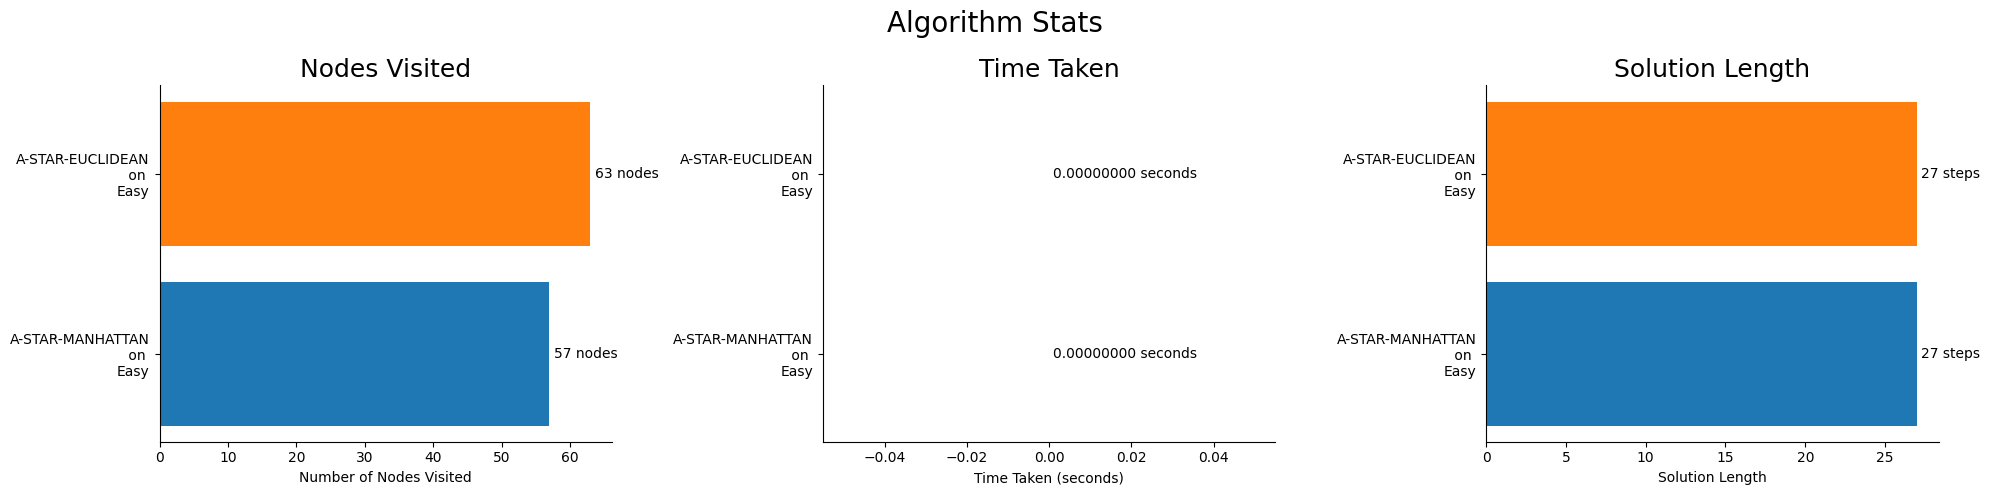

------------------- ANALYSIS ON MEDIUM -------------------


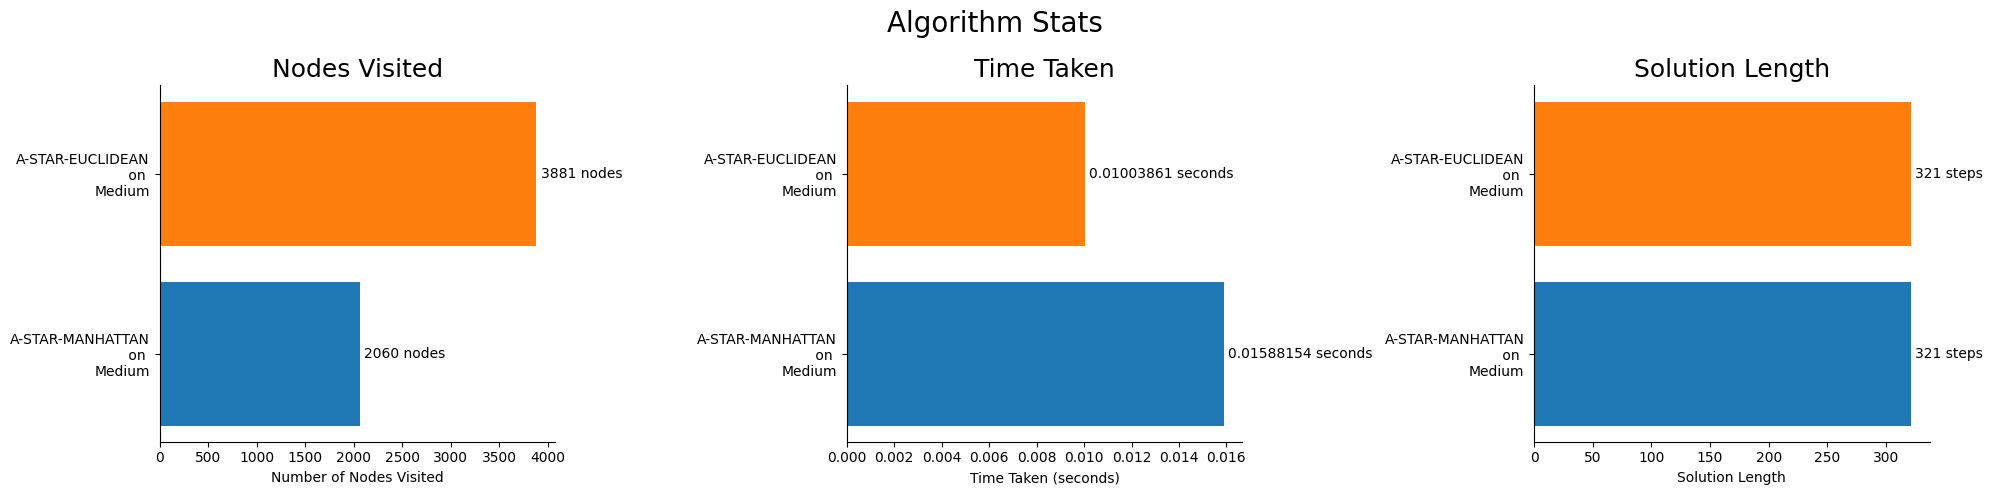

------------------- ANALYSIS ON LARGE -------------------


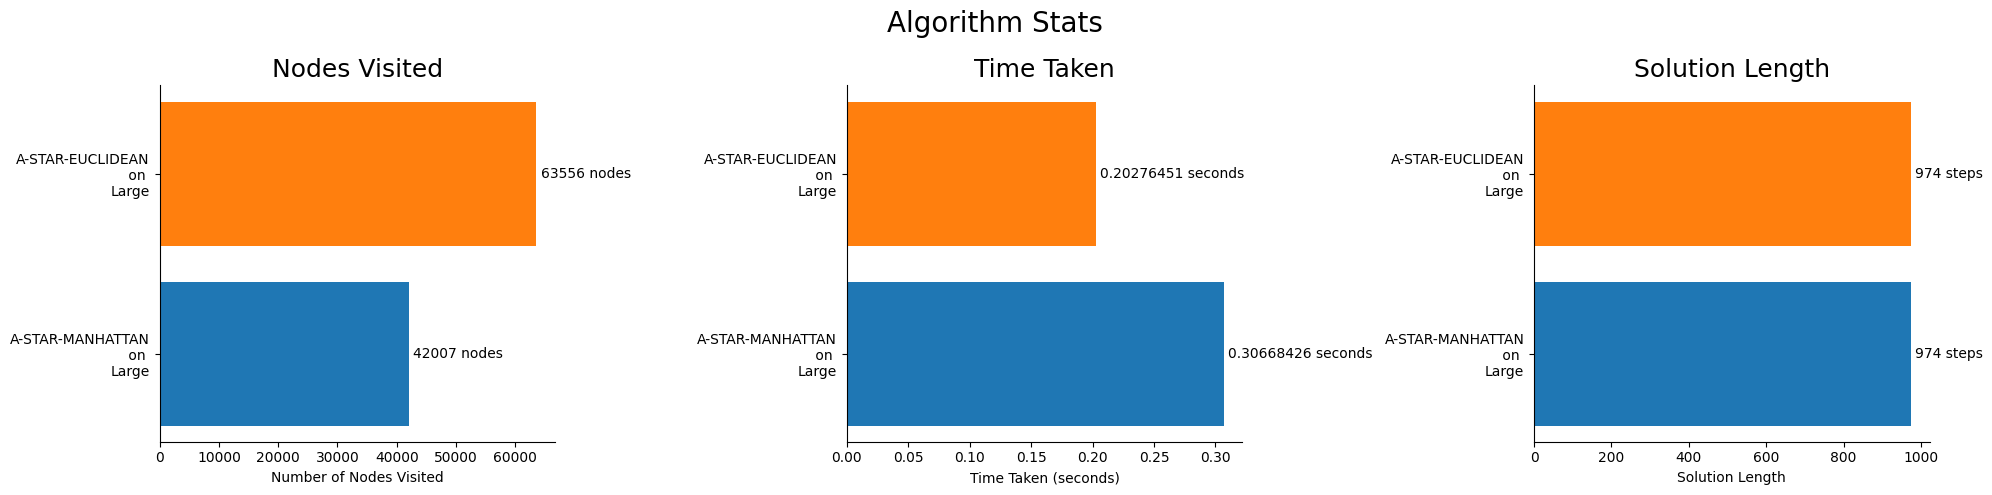

------------------- ANALYSIS ON VERY LARGE -------------------


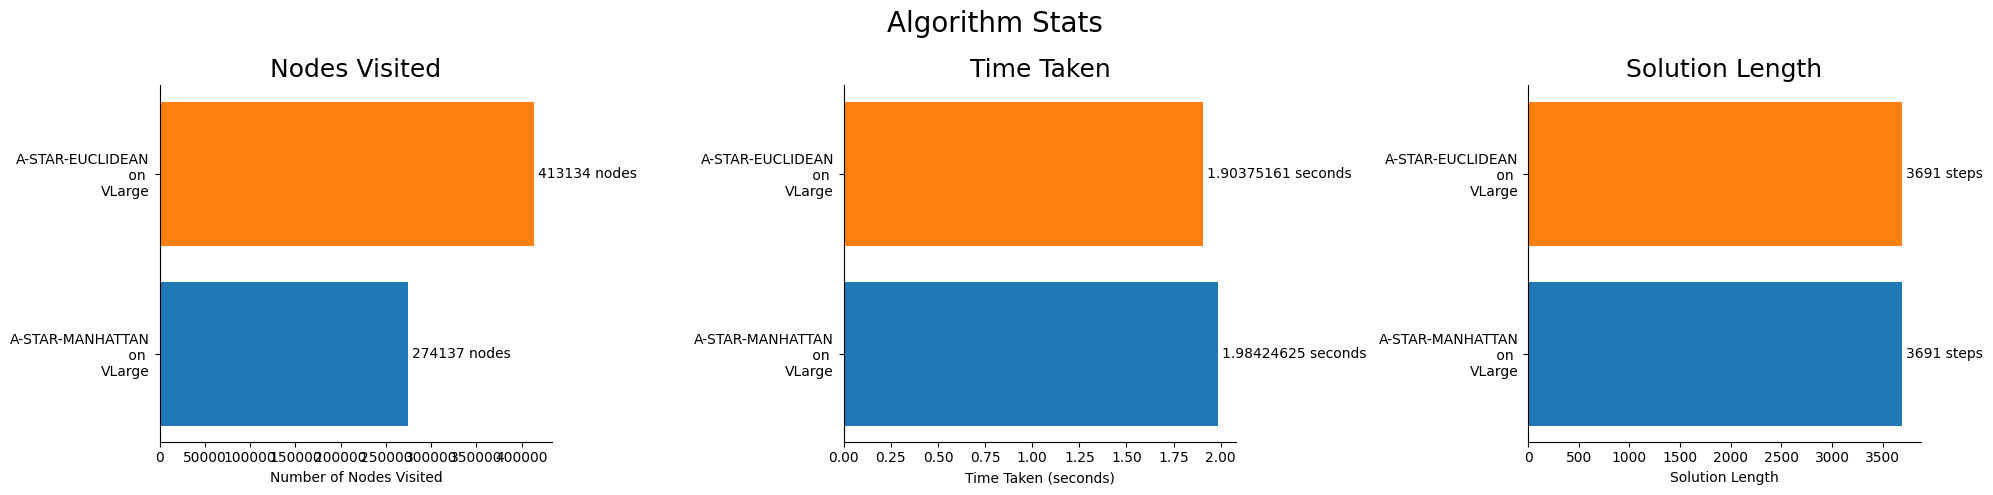

In [52]:
"""Stats of the A star search algorithm, Manhattan Heuristic vs Euclidean Heuristic"""

print("------------------- ANALYSIS ON EASY -------------------")
analysis_astar_easy = Analysis([astar_easy_manhattan, astar_easy_euclidean])
analysis_astar_easy.compare_stats()

print("------------------- ANALYSIS ON MEDIUM -------------------")
analysis_astar_medium = Analysis([astar_medium_manhattan, astar_medium_euclidean])
analysis_astar_medium.compare_stats()

print("------------------- ANALYSIS ON LARGE -------------------")
analysis_astar_large = Analysis([astar_large_manhattan, astar_large_euclidean])
analysis_astar_large.compare_stats()

print("------------------- ANALYSIS ON VERY LARGE -------------------")
analysis_astar_vlarge = Analysis([astar_vlarge_manhattan, astar_vlarge_euclidean])
analysis_astar_vlarge.compare_stats()

With the A-Star analysis, we can say that the manhattan distance is a better heuristic! This is because it is more accurate for grid-based problems where the agent can only move in four directions (up, down, left, and right) and cannot move diagonally.

It's reassuring to see that they share the same amount of steps, as both heuristics are admissible.